# 1 Author

**Student Name**: Desislava Kukova 
**Student ID**:  190480293

# 2 Problem formulation

ML Problem: Using the MLEnd Yummy Dataset, build a machine learning pipeline that takes as an input a photo of a dish that has either rice or chips and predicts whether the picture has rice or chips.

Interesting Aspects:

- Manually labeling the dataset to predict whether a dish contains rice or chips from a diverse dataset.
- Extracting features from the images suitable for such classification
- Selecting the models
- Using multiple models to provide comparative analysis of different algorithms
- Performing a grid search to find optimal hyperparameters
- Evaluating the models on metrics like accuracy, f1-score, specificity, etc.
- Handling the various presentations and compostions of dishes with rice or chips
- Distinguishing between similarly looking dishes
- Feature contribution to model's decison

# Preamble

In [1]:
# envrionment set up
!pip install --upgrade mlend

In [2]:
import mlend
from mlend import download_yummy, yummy_load

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
import glob

In [5]:
import os

In [6]:
import cv2

In [7]:
import spkit as sp

In [8]:
from skimage.color import rgb2hsv, rgb2gray
from skimage.feature import graycomatrix, graycoprops
from skimage import exposure
from skimage import feature

C:\Users\desik\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated


In [98]:
from scipy.stats import moment
from scipy.stats import randint

In [10]:
import string

In [99]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

In [12]:
!pip install imbalanced-learn

In [13]:
from imblearn.over_sampling import SMOTE

# 3 Machine Learning pipeline

**Input**: MLYEnd Yummy Dataset - raw data

- **Data Collection and Preparation**

Assign rice and chips or not label
Gather the appropriate dataset

**Output:** labelled images

**Input:** The output above

- **Image processing**

Resize images to standard format

**Output:** Processed images ready for feature extraction

**Input:** The output above

- **Feature extraction and target values extraction**

Obtain features from the images: colour moments, GLCM, contrast and Hu moments features
encode target variable

**Output:** Feature and target arrays

**Input:** Specific problem, dataset and features

- **Model Selection**

**Output:** Specific machine learning models suitable for the problem, dataset and features: Logistic Regresion, Support Vector Classifier and Random Forest Classifier

**Input:** Feature and target arrays

- **Data splitting**

split the data into training, validation and testing subsets

**Output:** Train, validation and test subsets

**Input:** Train, validation and test subsets

- **Feature scaling**

The train, validation and test subsets are scaled for models: Logistic Regression and Support Vector Clasifier

**Output:** Scaled train, validation and test subsets

**Input:** Scaled train subset

- **Handling Imbalanced data**

The scaled train subset is resampled for models: Logistic Regression and Support Vector Clasifier

**Output:** Resampled scaled train subset

**Input:** Model and specific train set (scaled for models: Logistic Regression and Support Vector Clasifier)

- **Model Training**

Train the model on the train subset

**Output:** Trained model

**Input:** Trained model and validation subset (scaled for models: Logistic Regression and Support Vector Clasifier)

- **Validation and Tuning**

Validate the trained model on the validation subset and tune hyperparameters on the validation set. (scaled for models: Logistic Regression and Support Vector Clasifier)

**Output:** The better model out of the starting trained model or default model

**Input:** The better model and the test subset (scaled for models: Logistic Regression and Support Vector Clasifier)

- **Model testing and Evaluation**

The better model is tested an evaluated in the test subset with specific evaluation metrics: accuracy, precision, recall, F1 score

**Output:** Evaluation metrics for the better model

**Input:** Evaluation metrics for the better models for all selected models

- **Model comparisson**

The trained and configured models are evaluated and compared based accuracy, precision, recall, F1 score.

**Output:** The best performing model is chosen and ready for deployment

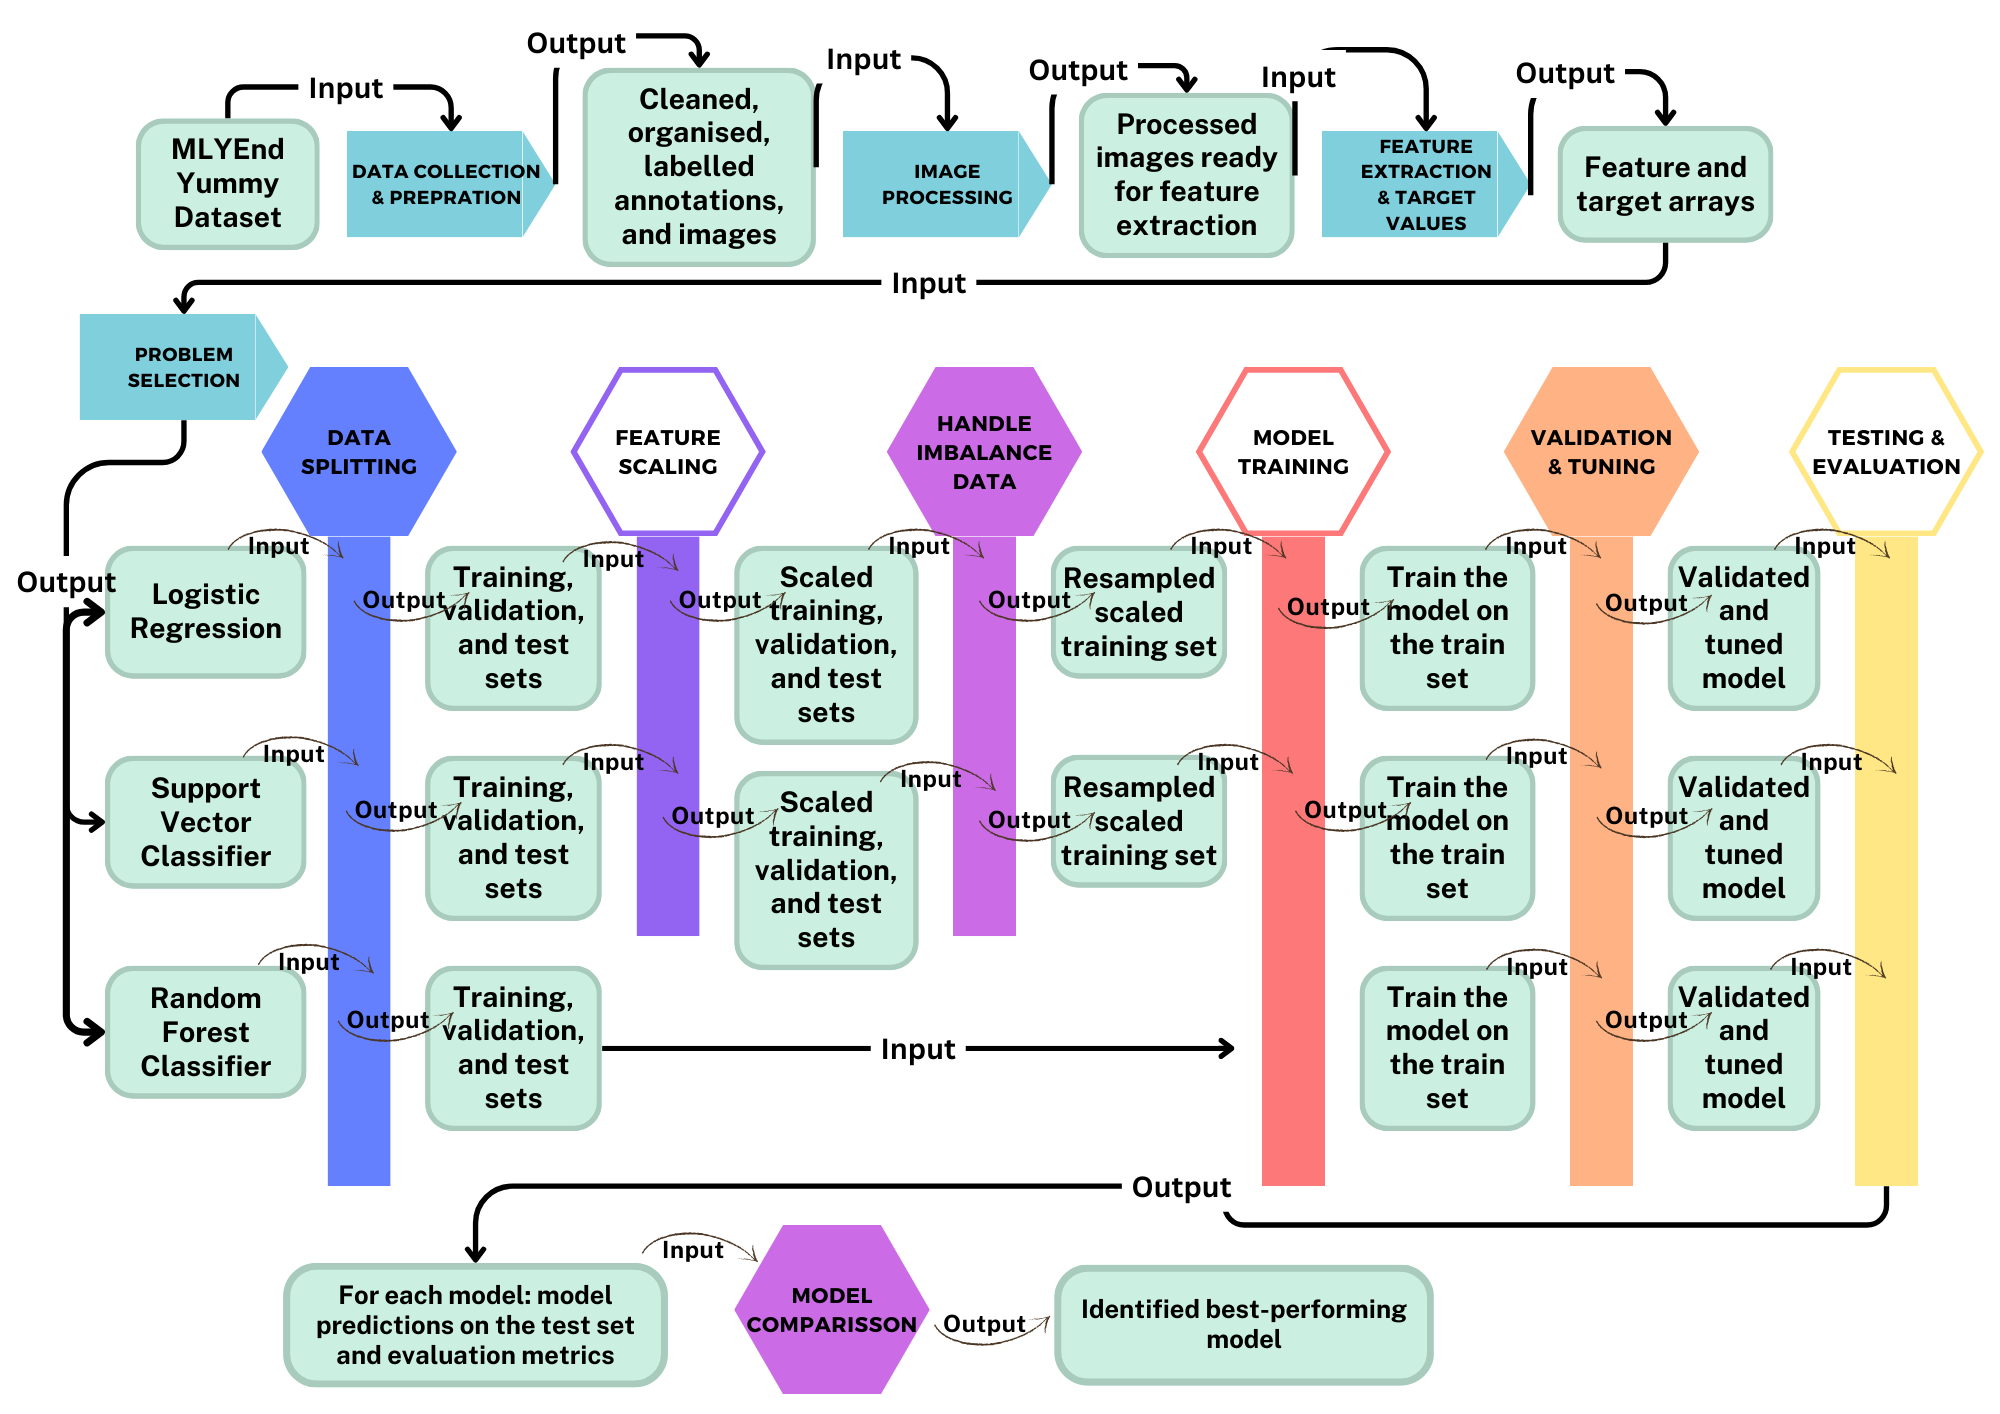

# 4 Transformation stage

In this section, the different transformations are described, input and output are identified as well as the rationale behind the transformation and an explanation of the implemented function.

## 4.1 Resizing stage

In this stage, we resize all images to ensure uniform size. Images of consistent size facilitate computational efficiency and ensure that the features extracted are comparable across different images.

Input: images (3D NumPy array with shape N x M x C)
Output: Resized image (NumPy array with shape size 224 x size 224 x C

**1st step - square the images**
Black colour is added to the images to square them to keep the original aspect ratio of each image.

In [14]:
def square_image(I, pad=0):
    """
    Square the input image by padding with a specified value.

    Parameters:
    - I: Input image (3D NumPy array with shape N x M x C).
    - pad: Value to use for padding (default is 0).

    Returns:
    - Square image (NumPy array with shape max(N, M) x max(N, M) x C).
    """

    N, M, C = I.shape
    if N > M:
        Is = [np.pad(I[:,:,i], [(0,0),(0, N-M)], 'constant', constant_values=pad) for i in range(C)]
    else:
        Is = [np.pad(I[:,:,i], [(0, M-N),(0,0)], 'constant', constant_values=pad) for i in range(C)]

    return np.array(Is).transpose([1, 2, 0])

**2nd step - Resize each picture to 224x224 pixels**
We have chosen this particular size due to its popularity for a good compromise between computational efficiency and capturing detailed features.

In [15]:
def resize_image(I, size=[224, 224]):
    """
    Resize the input image to a specified size.

    Parameters:
    - I: Input image (3D NumPy array with shape N x M x C).
    - size: Target size for resizing (default is [224, 224]).

    Returns:
    - Resized image (NumPy array with shape size[0] x size[1] x C).
    """

    N, M, C = I.shape
    Ir = [sp.resize(I[:,:,i], size) for i in range(C)]
    return np.array(Ir).transpose([1, 2, 0])

## 4.2 Feature Extraction

### 4.2.1 Colour Moments and Sum for Yellow Colour

**Rationale:**

Colour moments (mean, variance, skewness) serve as statistical indicators, revealing insights into the colour distribution within an image. This information is valuable for capturing the overall colour tone and variability, potentially reflecting the ingredients employed in the dish.

Conversely, potato chips are associated with yellow colour. Notably, certain dishes exhibit distinctive yellow colours, such as curry dishes with rice. In dish classification, where yellow is associated with particular ingredients or cooking styles, the calculated features become pertinent for accurate predictions.

**Function Explanation:**

The function `yellow_features` is designed to extract colour moments features from yellow regions within an RGB image. Specifically tailored for distinguishing between dishes with rice or chips, it focuses on capturing statistical attributes (mean, variance, skewness) of the yellow colour regions. The function employs threshold values (t1 and t2) to delineate the range of hues considered yellow. Additionally, it determines the count of yellow pixels in the image.

In [16]:
def yellow_features(I, t1=27, t2=33):
    """
    Extract colour moments features from the yellow regions of an RGB image,
    and the number of yellow pixels in the image to capture yellow colour information.

    Parameters:
    - I: Input RGB image (3D NumPy array with shape N x M x 3).
    - t1: Lower threshold for hue channel (default is 27).
    - t2: Upper threshold for hue channel (default is 33).

    Returns:
    - Colour moments features (mean_value, variance_value, skewness_value) for yellow regions,
    and number of yellow pixels in the image (Ypx).
    """

    # Convert RGB image to HSV colour space
    Ihsv = (rgb2hsv(I)*255).astype('uint8')

    # Create a mask for yellow regions based on hue values
    mask = (Ihsv[:, :, 0] >= t1) & (Ihsv[:, :, 0] <= t2)

    # Extract pixel values for yellow regions in each channel
    yellow_values = np.zeros_like(I)
    for channel in range(3):
        yellow_values[:, :, channel] = I[:, :, channel] * mask

    # Compute colour moments for each channel in the yellow regions
    moments_features = []
    for channel in range(3):
        channel_values = yellow_values[:, :, channel][mask]

        # Compute colour moments (mean, variance, skewness)
        mean_value = np.mean(channel_values)
        variance_value = np.var(channel_values)
        skewness_value = moment(channel_values, moment=3)
    
    # Compute the number of yellow pixels in the image
    Ypx = mask.sum()

    return mean_value, variance_value, skewness_value, Ypx

### 4.2.2 Texture Features from Gray-Level Co-occurrence Matrix

**Rationale:**

Potentially, rice and chips could have distinctive textual patterns suitable for distinguishing between the two types of dishes. 

**Function Explanation:**

The function `GMLC_features` extracts Gray-Level Co-occurrence Matrix (GLCM) features from the grayscale version of an RGB image. The function prioritises texture information by converting the RGB image to grayscale by eliminating colour-related disparities. The extracted texture features, dissimilarity, correlation, homogeneity and energy provide valuable insights into the spatial relationships of pixel intensities, potentially relevant for discriminating between rice and chips.

In [17]:
def GLCM_features(I):
    """
    Extract Gray-Level Co-occurrence Matrix (GLCM) features: dissimilarity and correlation,
    from a grayscale version of an RGB image.

    Parameters:
    - I: Input RGB image (3D NumPy array with shape N x M x 3).

    Returns:
    - Four texture features: dissimilarity, correlation, homogeneity and energy
    """

    # Convert the image to grayscale
    Ig = (rgb2gray(I)*255).astype('uint8')
    
    # Compute the gray-level co-occurrence matrix
    glcm = graycomatrix(Ig, distances=[5], angles=[0], levels=256,symmetric=True, normed=True)
    
    # Extracts texture features from GLCM
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    
    return dissimilarity, correlation, homogeneity, energy

### 4.2.3 Contrast

**Rationale:**

Contrast measures quantify the difference between light and dark regions in the image. Differences in contrast can be informative for distinguishing between various components in a dish, such as rice and chips.

**Function Explanation:**

Function Explanation:
The function extracts contrast features from a grayscale version of an RGB image. 
The standard deviation of pixel intensities measures the variability of intensity values in the image. The Root Mean Square (RMS) contrast of the pixel intensities measures overall contrast in the image.

In [18]:
def contrast_features(I):
    """
    Extract contrast features from a grayscale version of an RGB image.

    Parameters:
    - I: Input RGB image (3D NumPy array with shape N x M x 3).

    Returns:
    - Three contrast features: low_contrast, std_intensity and rms_contrast_value
    """

    # Convert the image to grayscale
    Ig = (rgb2gray(I)*255).astype('uint8')

    # Calculate standard deviation of pixel intensities
    std_intensity = np.std(Ig)
    
    # Calculate Root Mean Square contrast
    rms_contrast_value = np.sqrt(np.mean(Ig**2))

    return std_intensity, rms_contrast_value

### 4.2.3 Hu Moments

**Rationale:**

Hu Moments, comprising seven scalar values, serve as valuable shape descriptors in image processing and pattern recognition. These moments are derived from central moments, statistical measures capturing the spatial distribution of intensity in an image. In the context of classifying images of dishes containing either rice or chips, it could capture essential shape features for effective classification.

Hu Moment 1 (HU1) is invariant to translation changes and captures the overall scale or size of the object.<br>
Hu Moment 2 (HU2) is invariant to changes in scale and represents the rotationally invariant part of the shape.<br>
Hu Moment 3 (HU3) and Hu Moment 4 (HU4) are invariant to changes in rotation and capture the information related to the orientation or tilt of the object.<br>
Hu Moment 5 (HU5) is also invariant to changes in rotation and provides additional rotational information. <br>
Hu Moment 6 (HU6) and Hu Moment 7 (HU7) are invariant to changes in reflection and capture information related to whether the object is reflected or mirrored.

**Function Explanation:**

The function captures essential shape features. First, the RGB image is converted to grayscale. Then, the image moments are computed, and the Hu Moments are calculated based on them.

In [19]:
def extract_hu_moments(I):
    """
    Extract Hu Moments as shape features from an RGB image.

    Parameters:
    - I: Input RGB image (3D NumPy array with shape N x M x 3).

    Returns:
    - hu_moments_flat - Hu Moments (7 values)
    """

    # Convert the RGB image to grayscale
    Ig = (rgb2gray(I)*255).astype('uint8')

    # Compute Hu Moments
    moments = cv2.moments(Ig)
    hu_moments = cv2.HuMoments(moments)
    
    # Flatten the array
    hu1, hu2, hu3, hu4, hu5, hu6, hu7 = np.concatenate(hu_moments).flatten()

    return hu1, hu2, hu3, hu4, hu5, hu6, hu7

# 5 Modelling

In this section the chosen models are described and the rationale behind the choice is given.

## 5.1 Logistic Regression

**Rationale for choosing this particular model:**
- Suitable for binary classification tasks, such as classifying whether a picture has rice or chips.
- Easy to interpret
- Efficiency with small datasets
- Suitable for capturing non-linear relationships
- Easy to regularise to prevent overfitting

## 5.2 Support Vector Classifier (SVC)

**Rationale for choosing this particular model:**
- Suitable for binary classifications
- Suitable for high-dimensional data
- Suitable for handling non-linear decision boundaries
- Robust to overfitting and beneficial for relatively small data sets.
- Regulation parameter (C) can be adjusted to control the trade-off between having a smooth decision boundary and classifying the training point correctly
- SVC aims to maximise the margin between classes, which helps in generalising unseen data
- The Radial Basis Function (RBF) could capture localised patterns in the data

## 5.3 Random Forest

**Rationale for choosing this particular model:**
- Robust to overfitting as it is an ensemble learning method
- Capable of handling high-dimensional data
- Suitable for capturing complex relationships and interactions between features
- Provides feature importance score
- Handles features with different scales
- Handles imbalanced data well and prevents bias towards the majority class
- Generalises well to new data

# 6 Methodology

In this section, the methodology for each model is given.

## 6.1 Logistic Regression

**Data Splitting**
Train-Validation-Test Split with split ratio 60-20-20 and ensure that each set maintains the same class distribution as the original.

**Feature Scaling**
Perform normalisation on the features

**Handle Imbalanced Data**
Apply SMOTE to oversample the minority class in the training set to address the class imbalance and avoid leakage.

**Model Training**
Train the logistic regression model with default parameters on the training set to learn optimal weights for the features.

**Validation and Hyperparameter Tuning**
Perform grid search with 5-fold cross-validation and use the accuracy as evaluation metric.<br>
Accuracy is used beacause the aim is to predict whether the picture has rice or chips.<br>
Tune hyperparameters for logistic regression:<br>
C - the regularisation parameter;<br>
Penalty - the type of regularisation used 'l1' or 'l2'.<br>
Choose model by asssesing performance through accuracy, F1-score, precision, recall and specificity.

**Model Evaluation**
Evaluate the chosen model on the test set.
Assess the model performance through accuracy, precision, recall, specificity, F1-score and confusion matrix

## 6.2 SVC

**Data Splitting**
Train-Validation-Test Split with split ratio 60-20-20 and ensure that each set maintains the same class distribution as the original.

**Feature Scaling**
Perform normalisation on the features

**Handle Imbalanced Data**
Apply SMOTE to oversample the minority class in the training set to address the class imbalance and avoid leakage.

**Model Training**
Train the SVC model with kernel RBF and the rest with default parameters

**Validation and Hyperparameter Tuning**
Perform grid search with 5-fold cross-validation and use the accuracy as evaluation metric.<br>
Accuracy is used beacause the aim is to predict whether the picture has rice or chips.<br>
Tune hyperparameters for SVC:<br>
C - the regularisation parameter;<br>
Gamma - hyperparameter for radial basis function (RBF) kernel that defines the influence of a single training example;<br>
Class Weights - hyperparameter that assigns different weights to different classes.<br>
Choose model by asssesing performance through accuracy, F1-score, precision, recall and specificity.

**Model Evaluation**
Evaluate the chosen model on the test set.
Assess the model performance through accuracy, precision, recall, specificity, F1-score and confusion matrix

## 6.3 Random Forest

**Data Splitting**
Train-Validation-Test Split with split ratio 60-20-20 and ensure that each set maintains the same class distribution as the original.

**Model Training**
Train the model on the training set with default hyperparameters.

**Validation and Hyperparameter Tuning**
Perform randomised search with 5-fold cross-validation and use the accuracy as evaluation metric.<br>
Accuracy is used beacause the aim is to predict whether the picture has rice or chips.<br>
Tune hyperparameters for RF:<br>
N Estimators - number of trees in the forest; <br>
Max Depth - maximum depth of the trees;<br>
Min Samples Split - minimum number of samples required to split an internal node;<br>
Min Samples Leaf - minimum number of samples required to be at a leaf node. Higher values tend to prevent overfitting;<br>
Class Weights - hyperparameter that assigns different weights to different classes.<br>
Choose model by asssesing performance through accuracy, F1-score, precision, recall and specificity.

**Model Evaluation**
Evaluate the chosen model on the test set.
Assess the model performance through accuracy, precision, recall, specificity, F1-score and confusion matrix

# 7 Dataset

In this section the dataset used to create and validate the models is described.

We would use the MLEnd Yummy Dataset to create our models and validate them.

The MLEnd Yummy Dataset is a collection of more than 3,000 enriched images from over 200 participants collected in 2023. The images contain pictures of different dishes and each picture is annotated with attributes such as dish name, home or restaurant, cuisine, ingredients, diet, healthiness rating and likeness rating.

## 7.1 Gathering the dataset for the defined problem

Firstly, the datset is downloaded and checked that is available for use - there should be 3250 images.

In [20]:
subset = {}

datadir = download_yummy(save_to = r'C:\Users\desik\Desktop\ML\Mini Project\Data\MLEnd', subset = subset,verbose=1,overwrite=False)

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|3250\3250|003250.jpg
Done!


The contents of the folder where the MLEnd Dataset is saved are checked.

In [21]:
os.listdir(datadir)

['MLEndYD_images', 'MLEndYD_image_attributes_benchmark.csv']

The file `MLEndYD_image_attributes_benchmark.csv` which contains dataset information is saved to a variable and the name of the image is used as an index.

In [22]:
MLENDYD_df = pd.read_csv( r'C:\Users\desik\Desktop\ML\Mini Project\Data\MLEnd\yummy\MLEndYD_image_attributes_benchmark.csv').set_index('filename')
MLENDYD_df.head()

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A
filename,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train
000002.jpg,non_vegetarian,english,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",unhealthy,2.0,like,4.0,Train
000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train
000004.jpg,vegetarian,indian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",unhealthy,2.0,strongly_like,5.0,Train
000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train


Check for any missing values in the entire dataframe

In [23]:
# Check if there are any missing values in the entire DataFrame
any_missing = MLENDYD_df.isnull().sum().any()

if any_missing:
    # Display the columns with missing values and their counts
    missing_values = MLENDYD_df.isnull().sum()
    print("Missing Values in Each Column:")
    print(missing_values[missing_values > 0])
else:
    print("There are no missing values in the DataFrame.")

Missing Values in Each Column:
Cuisine_org               5
Cuisine                   5
Healthiness_rating        1
Healthiness_rating_int    1
Likeness                  4
Likeness_int              4
dtype: int64


The MLENDYD_df contains no missing values for Dish_name and Ingredients. Thus now we would check if it the downloaded images and the described images are the same size and whether there is a picture without a description or a discription without a picture.

In [24]:
# Get the list of downloaded image files
sample_path = r'C:\Users\desik\Desktop\ML\Mini Project\Data\MLEnd\yummy\MLEndYD_images\*.jpg'
files = glob.glob(sample_path)

# Extract the image names from the file paths
file_names = [file.split('\\')[-1] for file in files]

# Get the index of MLENDYD_df
df_names = MLENDYD_df.index

# Find images present in the MLENDYD_df but not in the downloaded files
missing_in_downloaded = set(df_names) - set(file_names)

# Find images present in the downloaded files but not in the MLENDYD_df
missing_in_df = set(file_names) - set(df_names)

# Display the results
if len(missing_in_downloaded) == 0 and len(missing_in_df)==0:
    print('The downloaded images and the images annotated in MLENDYD_df are the same.')
else:
    print("Number of Images Missing in Downloaded Files:", len(missing_in_downloaded))
    print("Images Missing in Downloaded Files:", missing_in_downloaded)
    print()
    print("\nNumber of Images Missing in DataFrame:", len(missing_in_df))
    print("Images Missing in DataFrame:", missing_in_df)

The downloaded images and the images annotated in MLENDYD_df are the same.


All strings in all columns of MLENDYD_df are to be coverted to lowercase.

In [25]:
MLENDYD_df = MLENDYD_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

A dataset that is representative of the problem needs to be gathered: pictures containing rice and chips.

For each image, it will be checked whether it contains rice or chips or none of them, and then the images that do not contain rice or chips will be removed.

In the determination of the label, the word "fries," a commonly used synonym for chips, will also be considered.

In [26]:
# Create a function to determine the value for Label
def determine_benchmark_b(row):
    if 'rice' in row['Dish_name'] or 'rice' in row['Ingredients']:
        return 'rice'
    elif 'chips' in row['Dish_name'] or 'fries' in row['Dish_name'] or 'chips' in row['Ingredients'] or 'fries' in row['Ingredients']:
        return 'chips'
    else:
        return 'NA'

# Apply the  function to create the Label column
MLENDYD_df['Label'] = MLENDYD_df.apply(determine_benchmark_b, axis=1)

# Remove rows with Label 'NA'
MLENDYD_df = MLENDYD_df[MLENDYD_df['Label'] != 'NA']
MLENDYD_df.head()

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Label
filename,,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,train,rice
000016.jpg,vegan,indian,indian,khichdi,home,"rice,spices,herbs",healthy,4.0,neutral,3.0,test,rice
000020.jpg,vegetarian,indian,indian,lentil-based_vegetable_stew_with__rice,home,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,healthy,4.0,like,4.0,test,rice
000021.jpg,non_vegetarian,asian,asian,biryani,home,"mutton,rice,onion,tomato,red_chilli_powder,sal...",healthy,4.0,strongly_like,5.0,train,rice
000022.jpg,vegetarian,indian,indian,rice_beetroot_curry,home,"rice,beetroot,salt,spices",very_healthy,5.0,neutral,3.0,train,rice


The character sequence "\n" representing a newline, and the special characters without "," and "_" are to be removed from Ingredients.

Asumption: "_" would keep the expressions together and "," would keep the different expressions separate

In [27]:
MLENDYD_df['Ingredients'] = MLENDYD_df['Ingredients'].str.replace("\n", ",")

special_characters = string.punctuation.replace(",", "").replace("_", "")
for char in special_characters:
    MLENDYD_df['Ingredients'] = MLENDYD_df['Ingredients'].str.replace(char, ",")

C:\Users\desik\AppData\Local\Temp\ipykernel_22128\2513762230.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


The detection of varying expressions containing the words "chips" or "fries" is to be performed for any images.

In [28]:
# Concatenate all ingredients into a single string
all_ingredients_text = ','.join(MLENDYD_df['Ingredients'].astype(str))

# Split the text into individual ingredient items using commas
all_words = all_ingredients_text.split(',')

# Get unique ingredient items containing 'chips' or 'fries'
unique_chips_fries_words = set(word for word in all_words if 'chips' in word or 'fries' in word)

# Display unique ingredient items 'chips' or 'fries'
for word in unique_chips_fries_words:
    print(word)

waffle_fries
chocolate_chips
dark_chocolate_chips
potato_fries
frozen_fries
white_chocolate_chips
artichoke_chips
chocolate_chips_and_vanilla_essence
choc_chips
chips
____peri_peri_chips
beef_patty_with_lettuce_cheddar_cheese__barbecue_sauce_fries_on_the_side_with_ketchup_salt_and_pepper
chunky_chips
peri_fries
potato_chips
fries
french_fries
chips，beans


From the above the following target words (words that are abnormal to use for potato chips) were deduced:
- waffle_fries,
- choc_chips,
- white_chocolate_chips,
- dark_chocolate_chips,
- chocolate_chips_and_vanilla_essence,
- chocolate_chips,
- artichoke_chips.

The description of images labeled as "chips" containing the specified target words will be investigated to ensure accurate labeling.


In [29]:
# Define the target words
target_words = ['waffle_fries', 'choc_chips', 'white_chocolate_chips','dark_chocolate_chips',
                'chocolate_chips_and_vanilla_essence', 'chocolate_chips', 'artichoke_chips']

# Create a boolean mask for rows containing the target words and where 'Label' is True
mask = (
    MLENDYD_df['Ingredients'].str.contains('|'.join(target_words), case=False) 
    & (MLENDYD_df['Label'] == 'chips')
)

# Filter the DataFrame
filtered_df = MLENDYD_df[mask]
filtered_df[['Dish_name', 'Ingredients']]

,Dish_name,Ingredients
filename,,
000138.jpg,banana_and_chocolate_chip_muffin,"chocolate_chips,self,raising_flour,caster_suga..."
000835.jpg,cup_cake,"wheat,yeast,choc_chips,egg,sugar"
001269.jpg,chocolate_twist,"puff_pastry_sheets,dark_chocolate_chips,egg,su..."
002002.jpg,white_chocolate_chip_cookie_dough,"brown_sugar,butter,granulated_sugar,milk,salt,..."
002040.jpg,protein_cookie_dough,"peanut_butter,protein_powder,chocolate_chips_a..."
002349.jpg,artichoke_taco,"tortilla_wrap,artichoke,huitaloche,guajillo_cr..."
002449.jpg,ferrero_rocher_cookie_dough,"brown_sugar,butter,nutella,hazelnuts,milk,salt..."
002875.jpg,beef_burger_and_cheesy_fries,"waffle_fries,cheese,brioche_bun,beef_patty,ghe..."
003166.jpg,chocochip_pancake,"chocolate_chips,maida,egg,butter,milk"


Based on the above only image 002875 is labeled correctly. The rest do not satisfy the labeling condition and would be removed.

In [30]:
# Remove rows from 'MLENDYD_df' based on indices in 'filtered_df.index' without picture 2875
indices_to_remove = filtered_df.index.difference(['002875.jpg'])
MLENDYD_df = MLENDYD_df.drop(indices_to_remove)

Similarly to the "chips" expression check, the detection of varying expressions such as "rice vinegar" or "rice wine" containing the word "rice" is to be performed for any images.

The check is only for "rice_" as the assumption is that a check for "_rice" would result in expressions such as "brown rice"or "plain rice" signifying the prsence of the ingredient rice in the picture.

In [31]:
# Split the text into individual ingredient items using commas
all_words = all_ingredients_text.split(',')

# Get unique ingredient items containing 'rice'
unique_rice_words = set(word for word in all_words if 'rice_' in word)

# Display unique ingredient items containing 'rice'
for word in unique_rice_words:
    print(word)

rice_vermicelli_noodle
rice_peanut_oil
fried_rice_masala
sweet_rice_flour
rice_vinegar
_rice_flour
paste_of_rice_and_black_gram
rice_n_pea
rice_cakes
rice_ingredients
rice_and_indian_spices
rice_and_potatos
puttu_rice_flour
rice_cake
brown_rice_with_herbs
rice_crisps
rice_flour
rice_noodle
chinese_rice_vinegar
cooked_rice_noodles
white_or_rice_vinegar
_rice_flour_batter
rice_batter
rice_noodles
flat_rice_noodles
grain_rice_
rice_dough
rice_flour_batter
rice_wine_vinegar
rice_spaghetti
5_cups_basmati_rice_
rice_urad_dal_batter
rice_with_meet_and_middle_eastern_spices
rice_flakes
1_cup_rice_
beaten_rice_flakes


It will be checked whether any images containing these words in the ingredients do not have the word "rice" in the dish name.

If the word "rice" is in the dish name, it signifies the presence of the ingredient "rice" in the picture.

In [32]:
# Create a boolean mask for rows containing the target words and where 'Label' is True and where 'Dish_name' does not conttain rice
mask = (
    MLENDYD_df['Ingredients'].str.contains('|'.join(unique_rice_words), case=False) 
    & (MLENDYD_df['Label'] == 'rice')
    & ~MLENDYD_df['Dish_name'].str.contains('rice', case=False)
)

# Filter the DataFrame
filtered_df = MLENDYD_df[mask]

print(f' There are {len(filtered_df)} images without the word rice in the dish name.')

 There are 72 images without the word rice in the dish name.


The detection of varying expressions containing the word "rice" is to be performed for the images in the filetered_df, where the word "rice" is not present in the dish name.

In [33]:
# Concatenate all ingredients into a single string
all_ingredients_text = ','.join(filtered_df['Ingredients'].astype(str))

# Split the text into ingredient items using commas
all_words = all_ingredients_text.split(',')

# Get unique ingredient items containing 'rice'
unique_rice_word = set(word for word in all_words if 'rice' in word)

# Display unique ingredient items containing 'rice'
for word in unique_rice_word:
    print(word)

rice_vermicelli_noodle
sushi_rice
rice_vinegar
_rice_flour
paste_of_rice_and_black_gram
boiled_rice
sweet_rice_flour
rice_n_pea
rice_cakes
puttu_rice_flour
rice_cake
rice_crisps
rice_flour
rice_noodle
_rice
rice
chinese_rice_vinegar
cooked_rice_noodles
white_or_rice_vinegar
_rice_flour_batter
rice_batter
rice_flakes
rice_noodles
flat_rice_noodles
rice_flour_batter
rice_wine_vinegar
rice_spaghetti
rice_urad_dal_batter
rice_dough
1_cup_rice_
beaten_rice_flakes


From the above the following target words (words that are normal to use for rice) were deduced:

- boiled_rice,
- _rice,
- rice_n_pea
- sushi_rice
- 1_cup_rice_

The description of images labeled as "rice" containing the specified target words will be investigated to ensure accurate labeling.

In [34]:
# Define the target words
target_words = ['boiled_rice', '_rice', 'rice_n_pea','sushi_rice', '1_cup_rice_']

# Create a boolean mask for rows containing the target words and where 'Label' is True
mask = (filtered_df['Ingredients'].str.contains('|'.join(target_words), case=False)
       & (filtered_df['Label'] == 'rice'))

# Filter the DataFrame
filtered_df_2 = filtered_df[mask]
filtered_df_2[['Dish_name', 'Ingredients']]

,Dish_name,Ingredients
filename,,
000159.jpg,tokyo_salmon_set,"salmon,sushi_rice,rice_vinegar,wakame_seaweed,..."
000165.jpg,jerk_pork_chop,"rice_n_pea,s,pork_chop,roasted_sweetcorn,gravy..."
000382.jpg,roti_and_mutton_curry,"for_roti,_rice_flour,water,salt_to_taste,ghee_..."
000428.jpg,jerk_pork_chop,"rice_n_pea,s,roasted_cobette,pork"
000431.jpg,kedgeree,"ingredients,,1_cup_rice_,white_or_brown,,1,2_c..."
001078.jpg,puttu_with_kdala_curry,"puttu_rice_flour,grated_coconut,water,salt,bla..."
001443.jpg,crispy_chinese_chicken,"vegetable_oil,eggs,cornstarch,flour,salt,peppe..."
001453.jpg,south_indian_meals,"groundnut_chutney,_groundnut,_red_chilly,_salt..."
001576.jpg,salmon_maki,"boiled_rice,salmon,seaweed,cucumber,sweet_corn..."


Based on the above only images 159, 165, 428, 431, 1443, 1453, 1576, 3043 is labeled correctly. The rest do not satisfy the labeling condition and would be removed.

The indexes for filteres_df are used as they contain all the images without "rice" in the dish name, but cotaing an ingredient item with the word "rice"

In [35]:
# Remove rows from 'MLENDYD_df' based on indices in 'filtered_df.index'
indices_to_remove = filtered_df.index.difference(['000159.jpg', '000165.jpg', '000428.jpg', '000431.jpg',
                                                  '001443.jpg', '001453.jpg', '001576.jpg','003043.jpg'])
MLENDYD_df = MLENDYD_df.drop(indices_to_remove)

Thus the gathering of the dataset is completed.

## 7.2 Data Exploration and Preporcessing

Firstly, the number of pictures for each class is calculated.

In [36]:
chips_count = MLENDYD_df[MLENDYD_df['Label'] == 'chips'].shape[0]
rice_count = MLENDYD_df[MLENDYD_df['Label'] == 'rice'].shape[0]
print(f"The number of images labeled with 'chips' is: {chips_count}")
print(f"The number of images labeled with 'rice' is: {rice_count}")

The number of images labeled with 'chips' is: 137
The number of images labeled with 'rice' is: 738


The bar chart below displays the class distribution in the dataset. It displays the number of images labeled as "chips" and "rice". The height of each bar represents the count of images for the corresponding class.

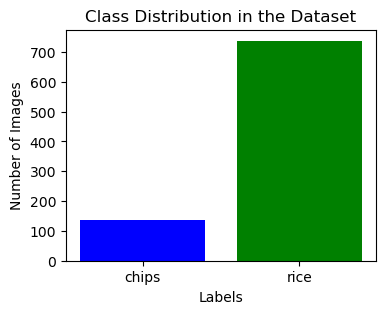

In [253]:
labels = ['chips', 'rice']
counts = [chips_count, rice_count]
plt.figure(figsize=(4, 3))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Class Distribution in the Dataset')
plt.show()

The rice class significantly outnumbers the chips class, thus resulting in a imbalanced set.

This would be addressed by oversampling the minority class in the training set for models Logisitc Regression and SVC, and trough stratified sampling while splitting the data into training, validation, and test sets for Random Forest model.

Five pictures from the MLENDYD_df would be visualised for each class.

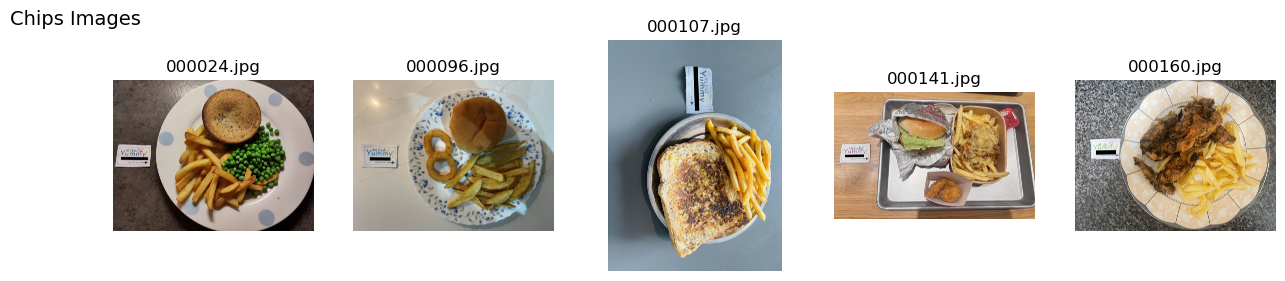

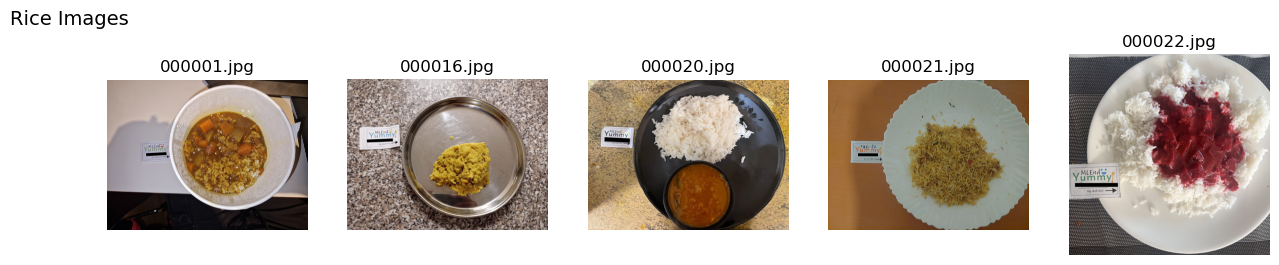

In [38]:
image_directory = r'C:\Users\desik\Desktop\ML\Mini Project\Data\MLEnd\yummy\MLEndYD_images'

# Filter images for chips and rice
chips_images = MLENDYD_df[MLENDYD_df['Label'] == 'chips'].index[:5]
rice_images = MLENDYD_df[MLENDYD_df['Label'] == 'rice'].index[:5]

# Function to display images
def display_images(image_paths, title):
    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=14, x=0.1)
    for i, img_path in enumerate(image_paths):
        plt.subplot(1, 5, i + 1)
        img = plt.imread(os.path.join(image_directory, img_path))
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_path)

display_images(chips_images, 'Chips Images')
display_images(rice_images, 'Rice Images')
plt.show()

As the images are of different sizes, there is the need to uniform them.

In [39]:
image_directory = r'C:\Users\desik\Desktop\ML\Mini Project\Data\MLEnd\yummy\MLEndYD_images'
Images = []

for k, (_, row) in enumerate(MLENDYD_df.iterrows()):
    I =plt.imread(os.path.join(image_directory, row.name))
    I = square_image(I, pad=0)
    I = resize_image(I, size=[224, 224])
    Images.append(I)
    sp.utils.ProgBar_JL(k, len(MLENDYD_df), L=50, color='blue')

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|875\875|
Done!


The shape of Images is checked.

In [40]:
Images = np.array(Images)
Images.shape

(875, 224, 224, 3)

The first 10 resized images are displayed.

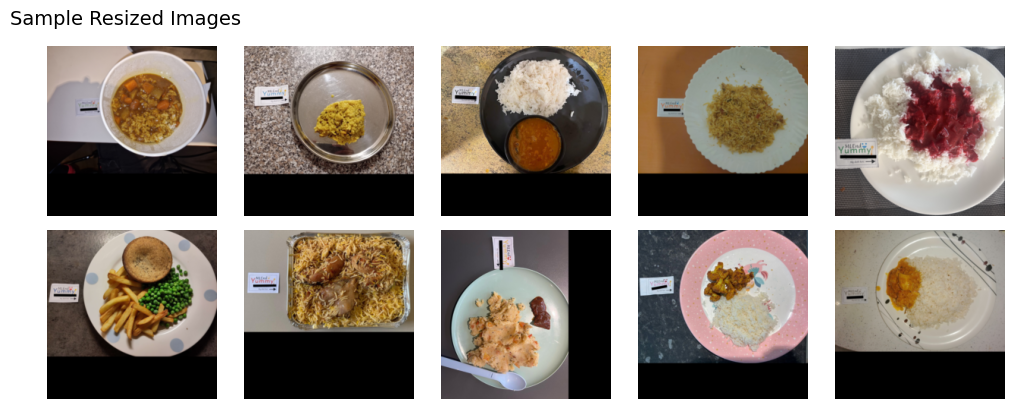

In [41]:
# Display the first 10 pitcures that were resized
plt.figure(figsize=(10,6))
for k,I in enumerate(Images):
    plt.subplot(3,5,k+1)
    plt.imshow(I)
    plt.axis('off')
    k+=1
    if k>=10:break
plt.suptitle('Sample Resized Images', fontsize=14, x=0.1)
plt.tight_layout()
plt.show()

## 7.3 Prediction Values

The first image from MLENDYD_df is displayed before resizing. The filename, dish name, given label and dimensions are also displayed.

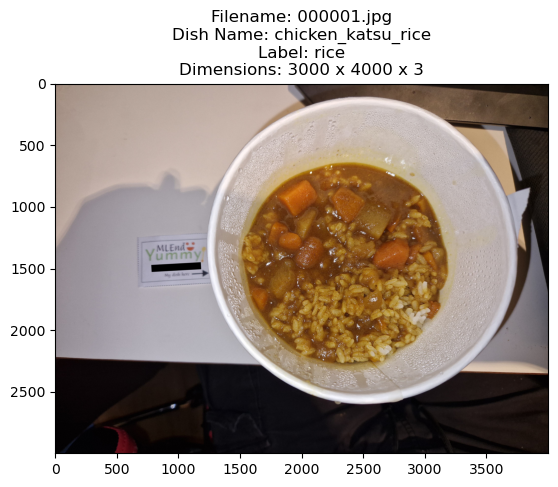

In [42]:
first_row = MLENDYD_df.iloc[0]
# Extract information from the row
filename = first_row.name
dish_name = first_row['Dish_name']
label = first_row['Label']

image_directory = r'C:\Users\desik\Desktop\ML\Mini Project\Data\MLEnd\yummy\MLEndYD_images'
img = plt.imread(os.path.join(image_directory, filename))
plt.imshow(img)
height, width, channels = img.shape
plt.title(f"Filename: {filename}\nDish Name: {dish_name}\nLabel: {label}\nDimensions: {height} x {width} x {channels}")
plt.show()

For each image, the label and file name is extracted. The label is also encoded and its map is displayed. The classification and the encoded classification is shown for the first few images.

In [254]:
y = []
filenames = []

for index, row in MLENDYD_df.iterrows():
    y.append(row['Label'])
    filenames.append(index)
    
# Convert lists to NumPy arrays
y = np.array(y)
filenames = np.array(filenames)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print('Label Mapping:')
for label, encoded_label in label_mapping.items():
    print(f'{label}: {encoded_label}')
    
y_df = pd.DataFrame({'filenames': filenames, 'y': y, 'y_encoded': y_encoded})
y_df.head()

Label Mapping:
chips: 0
rice: 1


,filenames,y,y_encoded
0,000001.jpg,rice,1
1,000016.jpg,rice,1
2,000020.jpg,rice,1
3,000021.jpg,rice,1
4,000022.jpg,rice,1


## 7.4 Feature Extraction

The first image from Images and its dimensions are displayed.

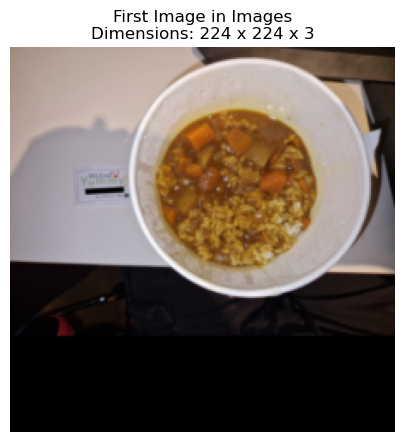

In [44]:
plt.figure(figsize=(5,5))
plt.imshow(Images[0])
height, width, channels = Images[0].shape
plt.title(f"First Image in Images\nDimensions: {height} x {width} x {channels}")
plt.axis('off')
plt.show()

For the first image from Images the features described in section 4.2 Feature Extraction are extracted and displayed.

In [45]:
print('Extracted features for the first image from Images\n')

print('Features from Colour Moments and Sum for Yellow Colour:')
f0, f1, f2, f3 = yellow_features(Images[0])
print(f'   The mean value for yellow regions is {f0}')
print(f'   The varience value for yellow regions is {f1}')
print(f'   The skewness value for yellow regions is {f2}')
print(f'   The number of yellow pixels in the image are {f3}\n')

print('Texture Features from Gray-Level Co-occurrence Matrix:')
f4, f5, f6, f7 = GLCM_features(Images[0])
print(f'   The dissimilarity is {f4}')
print(f'   The correlation is {f5}')
print(f'   The homogeneity is {f6}')
print(f'   The energy is {f7}\n')

print('Features from Contrast:')
f8, f9 = contrast_features(Images[0])
print(f'   The standard deviation of pixel intensities is {f8}')
print(f'   The Root Mean Square contrast is {f9}\n')

print('Features from Hu Moments:')
f10, f11, f12, f13, f14, f15, f16 = extract_hu_moments(Images[0])
print(f'   Translation Invariance\n      HU1 is {f10}')
print(f'   Scale Invarience\n      HU2 is {f11}')
print(f'   Rotation Invarience\n      HU3 is {f12}\n      HU4 is {f13}\n      HU5 is {f14}')
print(f'   Reflection Invarience\n      HU6 is {f15}\n      HU7 is {f16}')

Extracted features for the first image from Images

Features from Colour Moments and Sum for Yellow Colour:
   The mean value for yellow regions is 0.3558191777036484
   The varience value for yellow regions is 0.032617853278378364
   The skewness value for yellow regions is 0.004268562584485122
   The number of yellow pixels in the image are 1566

Texture Features from Gray-Level Co-occurrence Matrix:
   The dissimilarity is 10.884703196347033
   The correlation is 0.9492247128211775
   The homogeneity is 0.39716825170611486
   The energy is 0.2477018264591759

Features from Contrast:
   The standard deviation of pixel intensities is 77.95971613906035
   The Root Mean Square contrast is 9.113412582729985

Features from Hu Moments:
   Translation Invariance
      HU1 is 0.0012772498865315676
   Scale Invarience
      HU2 is 2.8472277837720806e-07
   Rotation Invarience
      HU3 is 5.889610992793273e-13
      HU4 is 7.952756900383481e-12
      HU5 is 1.6428662736130766e-23
   Reflectio

For each image, the above features are extracted. The exctracted features are displayed for the first few images.

In [46]:
X = []

for image in Images:
    # Feature extraction
    yellow_features_result = yellow_features(image)
    glcm_features_result = GLCM_features(image)
    contrast_features_result = contrast_features(image)
    hu_moments_result = extract_hu_moments(image)

    # Concatenate all features into a single array
    features = np.concatenate([
        yellow_features_result,
        glcm_features_result,
        contrast_features_result,
        hu_moments_result
    ])

    # Append features to X
    X.append(features)

# Convert list to NumPy arrays
X = np.array(X)

column_names = ['Mean for yellow regions', 'Varience for yellow regions', 'Skewness for yellow regions', 'Yellow pixels',
               'GLCM dissimilarity', 'GLCM correlation', 'GLCM homogeneity', 'GLCM energy',
                'STD pixel intensities', 'RMS Contrast',
                'HU1 - Translation Invariance', 'HU2 - Scale Invarience',
                'HU3 - Rotation Invarience', 'HU4 - Rotation Invarience', 'HU5 - Rotation Invarience',
                'HU6 - Reflection Invarience', 'HU7 - Reflection Invarience' ]
feature_df = pd.DataFrame(X, columns=column_names)

feature_df.head()

,Mean for yellow regions,Varience for yellow regions,Skewness for yellow regions,Yellow pixels,GLCM dissimilarity,GLCM correlation,GLCM homogeneity,GLCM energy,STD pixel intensities,RMS Contrast,HU1 - Translation Invariance,HU2 - Scale Invarience,HU3 - Rotation Invarience,HU4 - Rotation Invarience,HU5 - Rotation Invarience,HU6 - Reflection Invarience,HU7 - Reflection Invarience
0,0.355819,0.032618,0.004269,1566.0,10.884703,0.949225,0.397168,0.247702,77.959716,9.113413,0.001277,2.847228e-07,5.889611e-13,7.952757e-12,1.642866e-23,2.182098e-15,5.131894e-24
1,0.193699,0.011249,0.003584,2353.0,20.237524,0.886616,0.290916,0.241182,67.480498,8.759015,0.001323,1.536263e-07,1.250080e-12,8.435711e-12,-2.406934e-23,-3.055595e-15,-1.307992e-23
2,0.355583,0.026802,0.001247,4953.0,15.569247,0.911333,0.321590,0.246757,73.897223,9.049987,0.001595,2.451306e-07,7.446233e-11,5.928197e-11,-2.684971e-21,-1.382233e-14,-2.881708e-21
3,0.184664,0.004098,0.000515,5537.0,6.150603,0.968713,0.484922,0.247377,57.733515,9.389144,0.001430,1.712021e-07,2.180657e-12,5.540655e-12,9.297338e-24,1.438269e-15,1.686628e-23
4,0.721822,0.009125,-0.000483,10464.0,19.266736,0.878498,0.104113,0.013764,66.927095,10.647962,0.001146,1.138650e-09,6.318392e-12,6.044825e-12,2.874417e-23,1.869717e-16,2.386132e-23


For each image the filename, its label (y), the encoded label (y_encoded) and the features are saved to a data frame - features_class_df. The information for the first few images is displayed.

In [256]:
features_class_df = pd.merge(y_df, feature_df, left_index=True, right_index=True)

features_class_df.to_csv('features_class.csv', index=False)

features_class_df.head()

,filenames,y,y_encoded,Mean for yellow regions,Varience for yellow regions,Skewness for yellow regions,Yellow pixels,GLCM dissimilarity,GLCM correlation,GLCM homogeneity,GLCM energy,STD pixel intensities,RMS Contrast,HU1 - Translation Invariance,HU2 - Scale Invarience,HU3 - Rotation Invarience,HU4 - Rotation Invarience,HU5 - Rotation Invarience,HU6 - Reflection Invarience,HU7 - Reflection Invarience
0,000001.jpg,rice,1,0.355819,0.032618,0.004269,1566.0,10.884703,0.949225,0.397168,0.247702,77.959716,9.113413,0.001277,2.847228e-07,5.889611e-13,7.952757e-12,1.642866e-23,2.182098e-15,5.131894e-24
1,000016.jpg,rice,1,0.193699,0.011249,0.003584,2353.0,20.237524,0.886616,0.290916,0.241182,67.480498,8.759015,0.001323,1.536263e-07,1.250080e-12,8.435711e-12,-2.406934e-23,-3.055595e-15,-1.307992e-23
2,000020.jpg,rice,1,0.355583,0.026802,0.001247,4953.0,15.569247,0.911333,0.321590,0.246757,73.897223,9.049987,0.001595,2.451306e-07,7.446233e-11,5.928197e-11,-2.684971e-21,-1.382233e-14,-2.881708e-21
3,000021.jpg,rice,1,0.184664,0.004098,0.000515,5537.0,6.150603,0.968713,0.484922,0.247377,57.733515,9.389144,0.001430,1.712021e-07,2.180657e-12,5.540655e-12,9.297338e-24,1.438269e-15,1.686628e-23
4,000022.jpg,rice,1,0.721822,0.009125,-0.000483,10464.0,19.266736,0.878498,0.104113,0.013764,66.927095,10.647962,0.001146,1.138650e-09,6.318392e-12,6.044825e-12,2.874417e-23,1.869717e-16,2.386132e-23


# 8 Results

Firstly all the functions used in this section are displayed in section 8.0 Functions for more uniformed view.

Then for each of the chosen models in section 5 Modelling, the methodology described in section 6 Metodology is carried.

## 8.0 Functions

In [260]:
def data_splitting(X, y_encoded, test_size=0.4, random_state=42):
    """
    Train-Validation-Test Split with split ratio 60-20-20 with stratification.

    Parameters:
    - X: Feature matrix.
    - y_encoded: Target variable (encoded).
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Seed for random number generation.
    
    Prints:
    - thee shapes of the feature matrices for training, validation, and test sets.
    Returns:
    - X_train, X_val, X_test: Feature matrices for training, validation, and test sets.
    - y_train, y_val, y_test: Target variables for training, validation, and test sets.
    """
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state, stratify=y_temp)

    print('Shapes:')
    print(f'Training subset shape: {X_train.shape}')
    print(f'Validation subset shape: {X_val.shape}')
    print(f'Test subset shape: {X_test.shape}')

    return X_train, X_val, X_test, y_train, y_val, y_test

In [261]:
def feature_scaling(X_train, X_val, X_test):
    """
    Scale features using StandardScaler.

    Parameters:
    - X_train: Feature matrix for training set.
    - X_val: Feature matrix for validation set.
    - X_test: Feature matrix for test set.

    Returns:
    - X_train_scaled, X_val_scaled, X_test_scaled: Scaled feature matrices.
    """
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled

In [262]:
def evaluate_logreg_performance(model, name, X, feature_matrix_name, y):
    """
    Evaluate the performance of a logistic regression model on a given dataset.

    Parameters:
    - model: The trained classification model.
    - name: The name of the classification model
    - X: Feature matrix.
    - feature_matrix_name: Feature matrix name.
    - y: Target variable.
   
    Returns:
    - evaluation metrics as a DataFrame
    """

    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=1)
    recall = recall_score(y, y_pred, zero_division=1)
    
    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    return pd.DataFrame({
        'Model': [name],
        'Feature_Matrix': [feature_matrix_name],
        'C': [model.C] if hasattr(model, 'C') else None,
        'Penalty': [model.penalty] if hasattr(model, 'penalty') else None,
        'Solver': [model.solver] if hasattr(model, 'solver') else None,
        'Accuracy': [round(accuracy,6)],
        'Precision': [round(precision,6)],
        'Recall': [round(recall,6)],
        'Specificity': [round(specificity, 6)],
        'F1-score': [round(f1,6)]
    })

In [263]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot a confusion matrix using seaborn.

    Parameters:
    - y_true: True labels.
    - y_pred: Predicted labels.

    Returns:
    - None (displays the plot).
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    tn, fp, fn, tp = conf_matrix.ravel()

    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative\n(Class 0 - chips)', 'Actual Positive\n(Class 1 -rice)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.text(0.2, 0.5, 'TN', bbox=dict(facecolor='white', boxstyle='round,pad=0.3'))
    plt.text(1.2, 0.5, 'FP', bbox=dict(facecolor='white', boxstyle='round,pad=0.3'))
    plt.text(0.2, 1.5, 'FN', bbox=dict(facecolor='white', boxstyle='round,pad=0.3'))
    plt.text(1.2, 1.5, 'TP', bbox=dict(facecolor='white', boxstyle='round,pad=0.3'))

    plt.show()

In [264]:
def evaluate_SVC_performance(model, name, X, feature_matrix_name, y):
    """
    Evaluate the performance of a SVC model with RBF kernel on a given dataset.

    Parameters:
    - model: The trained classification model.
    - name: The name of the classification model
    - X: Feature matrix.
    - feature_matrix_name: Feature matrix name.
    - y: Target variable.
    
    def evaluate_logreg_performance(model, name, X, feature_matrix_name, y):
    """
    
    svc_params = model.get_params()
    
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=1)
    recall = recall_score(y, y_pred, zero_division=1)
    
    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    return pd.DataFrame({
        'Model': [name],
        'Feature_Matrix': [feature_matrix_name],
        'C': [svc_params['C']] ,
        'Gamma': [svc_params['gamma']],
        'Class_Weight': [svc_params['class_weight']],
        'Accuracy': [round(accuracy,6)],
        'Precision': [round(precision,6)],
        'Recall': [round(recall,6)],
        'Specificity': [round(specificity, 6)],
        'F1-score': [round(f1,6)]
    })

In [265]:
def evaluate_RF_performance(model, name, X, feature_matrix_name, y):
    """
    Evaluate the performance of a RF model on a given dataset.

    Parameters:
    - model: The trained classification model.
    - name: The name of the classification model
    - X: Feature matrix.
    - feature_matrix_name: Feature matrix name.
    - y: Target variable.
   
    Returns:
    - evaluation metrics as a DataFrame
    """
    
    rf_params = model.get_params()
    
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=1)
    recall = recall_score(y, y_pred, zero_division=1)
    
    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    return pd.DataFrame({
        'Model': [name],
        'Feature_Matrix': [feature_matrix_name],
        'N estimators': [rf_params['n_estimators']],
        'Max Depth': [rf_params['max_depth']],
        'Min Samples Split': [rf_params['min_samples_split']],
        'Min Samples Leaf': [rf_params['min_samples_leaf']],
        'Class Weight': [rf_params['class_weight']],
        'Accuracy': [round(accuracy,6)],
        'Precision': [round(precision,6)],
        'Recall': [round(recall,6)],
        'Specificity': [round(specificity, 6)],
        'F1-score': [round(f1,6)]
    })

## 8.1 Logistic Regresion Model 

### 8.1.1 Step 1: Data Splitting

In [269]:
logreg_X_train, logreg_X_val, logreg_X_test, logreg_y_train, logreg_y_val, logreg_y_test = data_splitting(X, y_encoded, test_size=0.4, random_state=42)

Shapes:
Training subset shape: (525, 17)
Validation subset shape: (175, 17)
Test subset shape: (175, 17)


### 8.1.2 Step 2: Feature Scaling

In [270]:
logreg_X_train_scaled, logreg_X_val_scaled, logreg_X_test_scaled = feature_scaling(logreg_X_train, logreg_X_val, logreg_X_test)

### 8.1.3 Step 3: Handle Imbalanced Data

In [271]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
logreg_X_train_resampled, logreg_y_train_resampled = smote.fit_resample(logreg_X_train_scaled, logreg_y_train)

### 8.1.4 Step 4: Model Training

In [105]:
# Train the logistic regression model with default parameters
logreg = LogisticRegression()
logreg.fit(logreg_X_train_resampled, logreg_y_train_resampled)

LogisticRegression()

In [274]:
# results on train subset with default logreg model
logreg_results_df = pd.DataFrame()
result = evaluate_logreg_performance(logreg, 'Dafault Logistic Regression', logreg_X_train_resampled, 'Train Resampled Subset', logreg_y_train_resampled)
logreg_results_df = pd.concat([logreg_results_df, result], ignore_index=True)
logreg_results_df 

,Model,Feature_Matrix,C,Penalty,Solver,Accuracy,Precision,Recall,Specificity,F1-score
0,Dafault Logistic Regression,Train Resampled Subset,1.0,l2,lbfgs,0.639955,0.640271,0.638826,0.641084,0.639548


The coefficients of the logistic regression model are displayed below.

In [108]:
# coefficients and feature names
coefficients = logreg.coef_[0]
feature_names = feature_df.columns  # get column names from feature df

coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coefficients_df['Absolute_Coefficient'] = coefficients_df['Coefficient'].abs()  # show importance
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

print('Logistic Regression Coefficients with default hyperparameters in descending order by coefficient:')
coefficients_df

Logistic Regression Coefficients with default hyperparameters in descending order by coefficient:


,Feature,Coefficient,Absolute_Coefficient
13,HU4 - Rotation Invarience,0.698108,0.698108
0,Mean for yellow regions,0.667528,0.667528
2,Skewness for yellow regions,0.320437,0.320437
9,RMS Contrast,0.291076,0.291076
6,GLCM homogeneity,0.270600,0.270600
1,Varience for yellow regions,0.261866,0.261866
7,GLCM energy,0.222202,0.222202
11,HU2 - Scale Invarience,0.205069,0.205069
3,Yellow pixels,0.079693,0.079693
12,HU3 - Rotation Invarience,0.069575,0.069575


For each coeffiecient the magnitude (size) and direction (sign) are displayed below:

The larger absolute values suggest a stronger impact. The sign suggests the direction of the relationship: a positive relationship with a positive sign and a negative relationship with a negative sign. As the features are scaled, the coefficients are directly comparable, suggesting GLCM disimilarity and HU7 moment have the biggest impact.

HU7 moment, which is invariant to changes in reflection, has the biggest influence with a value -1.367687 and is the only coefficient with a absolute value bigger than 1. The STD pixel inntesities has the second biggest impact with a value of -0.804262.

HU5 moment, which is invariant to changes in rotation has the least impact with a value close to zero of -0.000164.

Below the features are displayed in order of influence based on their respective coefficient.

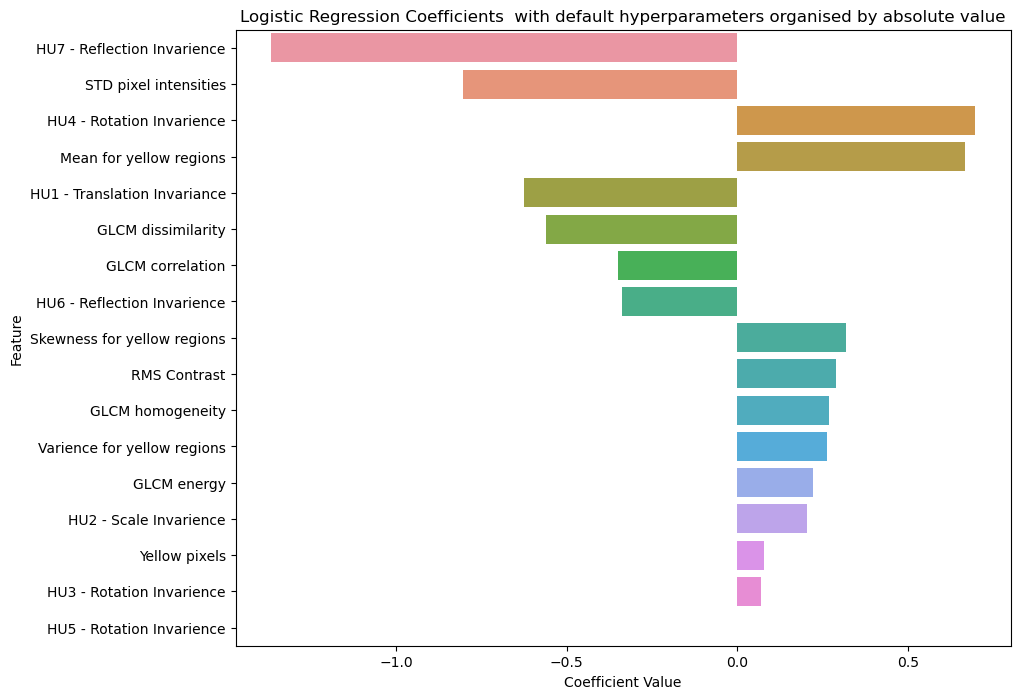

In [109]:
coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df)
plt.title('Logistic Regression Coefficients  with default hyperparameters organised by absolute value')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

### 8.1.5 Step 5: Validation and Hyperparameter Tuning

The parameters that are:

- C - the regulasation parameter that controls the trade-off between fitting the training data and preventing overfitting.
Smaller values of C result in stronger regularisation, penalising large coefficients and preventing overfitting.
Larger values of C reduce the regularisation strength to fit the data more closely.

- Penalty determines the type of regularisation applied to the model's coefficients. L1 (Lasso) adds the absolute values of the coefficients to the cost function. L2 (Ridge) adds the squared values of coeffiecients to the cost function.

In [275]:
# results on validation subset with default logreg model
result = evaluate_logreg_performance(logreg, 'Dafault Logistic Regression', logreg_X_val_scaled, 'Validation Subset', logreg_y_val)
logreg_results_df = pd.concat([logreg_results_df, result], ignore_index=True)

In [111]:
# grid search
logreg_param_grid = {'C': [0.1, 0.2, 0.5, 0.8, 1, 2, 5, 8, 10, 20, 50, 80, 100],
                     'penalty': ['l1','l2'],
                     'solver': ['liblinear']}

logreg_grid_search = GridSearchCV(logreg, logreg_param_grid, cv=5, scoring='accuracy', verbose=1)
logreg_grid_search.fit(logreg_X_val_scaled, logreg_y_val)

Fitting 5 folds for each of 26 candidates, totalling 130 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.2, 0.5, 0.8, 1, 2, 5, 8, 10, 20, 50, 80,
                               100],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy', verbose=1)

In [257]:
# get the tuned logreg model
tuned_logreg = logreg_grid_search.best_estimator_
print('The result for Best Logistic Regression Model with 5-fold cross-validation with accuracy as evaluation metric is:')
print(tuned_logreg)

The result for Best Logistic Regression Model with 5-fold cross-validation with accuracy as evaluation metric is:
LogisticRegression(C=0.1, penalty='l1', solver='liblinear')


In [267]:
# Retrain the tuned logreg model with the best hyperparameters on the Train Resampled Subset
tuned_logreg.fit(logreg_X_train_resampled, logreg_y_train_resampled)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [276]:
# results on train subset with tuned logreg model
result = evaluate_logreg_performance(tuned_logreg, 'Tuned Logistic Regression', logreg_X_train_resampled, 'Train Resampled Subset', logreg_y_train_resampled)
logreg_results_df = pd.concat([logreg_results_df, result], ignore_index=True)

In [277]:
# results on validation subset with tuned logreg model
result = evaluate_logreg_performance(tuned_logreg, 'Tuned Logistic Regression', logreg_X_val_scaled, 'Validation Subset', logreg_y_val)
logreg_results_df = pd.concat([logreg_results_df, result], ignore_index=True)

In [278]:
logreg_results_df

,Model,Feature_Matrix,C,Penalty,Solver,Accuracy,Precision,Recall,Specificity,F1-score
0,Dafault Logistic Regression,Train Resampled Subset,1.0,l2,lbfgs,0.639955,0.640271,0.638826,0.641084,0.639548
1,Dafault Logistic Regression,Validation Subset,1.0,l2,lbfgs,0.588571,0.872549,0.601351,0.518519,0.712000
2,Tuned Logistic Regression,Train Resampled Subset,0.1,l1,liblinear,0.652370,0.658824,0.632054,0.672686,0.645161
3,Tuned Logistic Regression,Validation Subset,0.1,l1,liblinear,0.605714,0.883495,0.614865,0.555556,0.725100


Default Logistic Regression Model (C=1, penalty='l2', solver='lbfgs')<br>
Tuned Logistic Regression Model (C=0.1, penalty='l1', solver='liblinear')

The evaluation metrics for both logistic regression models display comparable performance, with values falling within very similar ranges.

The Tuned Logistic Regression Model outperforms the Default Logistic Regresion Model (event though it is only slightly) on all evaluation metrics for train resampled subset and the unseen data - validation subset.

Thus the model that would be tested is Tuned Logistic Regression Model (C=0.1, penalty='l1', solver='liblinear').

### 8.1.6 Step 6: Model Evaluation

In [117]:
logreg_y_pred_test = tuned_logreg.predict(logreg_X_test_scaled)

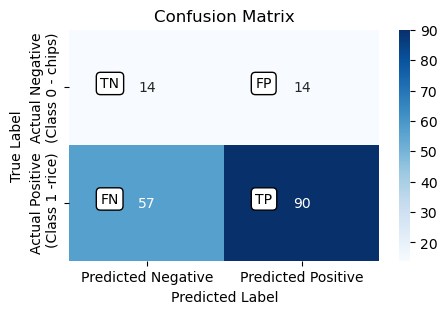

In [119]:
plot_confusion_matrix(logreg_y_test, logreg_y_pred_test)

True Negatives (TN): 14
instances that are actually in the chips class, and the model correctly predicted them as chips.

False Positives (FP): 14
instances that are actually in the chips class, but the model incorrectly predicted them as rice.

False Negatives (FN): 57
instances that are actually in the rice class, but the model incorrectly predicted them as chips.

True Positives (TP): 90
instances that are actually in the rice class, and the model correctly predicted them as rice

In [279]:
# results on test subset with default logreg model
result = evaluate_logreg_performance(tuned_logreg, 'Tuned Logistic Regression', logreg_X_test_scaled, 'Test Subset', logreg_y_test)
logreg_results_df = pd.concat([logreg_results_df, result], ignore_index=True)
logreg_results_df

,Model,Feature_Matrix,C,Penalty,Solver,Accuracy,Precision,Recall,Specificity,F1-score
0,Dafault Logistic Regression,Train Resampled Subset,1.0,l2,lbfgs,0.639955,0.640271,0.638826,0.641084,0.639548
1,Dafault Logistic Regression,Validation Subset,1.0,l2,lbfgs,0.588571,0.872549,0.601351,0.518519,0.712000
2,Tuned Logistic Regression,Train Resampled Subset,0.1,l1,liblinear,0.652370,0.658824,0.632054,0.672686,0.645161
3,Tuned Logistic Regression,Validation Subset,0.1,l1,liblinear,0.605714,0.883495,0.614865,0.555556,0.725100
4,Tuned Logistic Regression,Test Subset,0.1,l1,liblinear,0.594286,0.865385,0.612245,0.500000,0.717131


Accuracy measured as (TP + TN) / Total Count, is 59.43%. The model correctly labels 59.43% of the dishes.

Precision measured as TP / (TP + FP), is 86.54%, reasonably high precision. From all the predicted dishes as rice, 86.54%% are actually rice. The precision is higher due to relatively low FP (10).

Recall measured as TP / (TP + FN), is 61.22%, reasonaby low recall. From all the actual rice dishes, the model identified only 61.22% suggesting that the model missed the rice dishes almost half of the time.

Specificity measured as TN / (TN + FP), is 50%. From all the actual chips dishes, the model identified only half.

The F1 Score measured as (2 x Precision x Recall) / (Precision + Recall), is 71.71%.  It provides a balanced measure of the model's ability to make accurate positive predictions while avoiding false positives and false negatives.

Thus, the Tuned Logistic Regression (C=0.1, penalty='l1', solver='liblinear'), as configured and trained is facing challenges in effectively predicting the two classes chips and rice.

## 8.2 SVC

### 8.2.1 Step 1: Data Splitting

In [237]:
svc_X_train, svc_X_val, svc_X_test, svc_y_train, svc_y_val, svc_y_test = data_splitting(X, y_encoded, test_size=0.4, random_state=42)

Shapes:
Training subset shape: (525, 17)
Validation subset shape: (175, 17)
Test subset shape: (175, 17)


### 8.2.2 Step 2: Feature Scaling

In [238]:
svc_X_train_scaled, svc_X_val_scaled, svc_X_test_scaled = feature_scaling(svc_X_train, svc_X_val, svc_X_test)

### 8.2.3 Step 3: Handle Imbalanced Data

In [239]:
smote = SMOTE(sampling_strategy='auto',random_state=42)
svc_X_train_resampled, svc_y_train_resampled = smote.fit_resample(svc_X_train_scaled, svc_y_train)

### 8.2.4 Step 4: Model Training

In [240]:
# Train SVC model with default hyperparameters kernel RBF is default
svc = SVC()
svc.fit(svc_X_train_resampled, svc_y_train_resampled)

SVC()

In [297]:
# results on train subset with default svc model
svc_results_df = pd.DataFrame()
result = evaluate_SVC_performance(svc, 'Default SVC',svc_X_train_resampled, 'Train Resampled Subset', svc_y_train_resampled)
svc_results_df = pd.concat([svc_results_df, result], ignore_index=True)
svc_results_df 

,Model,Feature_Matrix,C,Gamma,Class_Weight,Accuracy,Precision,Recall,Specificity,F1-score
0,Default SVC,Train Resampled Subset,1.0,scale,None,0.808126,0.907463,0.68623,0.930023,0.781491


For SVC with the Radial Basis Function (RBF) kernel, interpreting the impact of individual features on predictions is not as straightforward as in linear models like logistic regression. SVC with RBF operate in a higher-dimensional space, and the decision boundary is determined by the relationships between all features collectively as such there are two important components support vectors and dual coefficients. The support vectors are the training instances that influence the placement of the decision boundary. The dual coefficients indicate the contribution of each support vector to the decision function. In a binary classification, positive coefficients suggest one class, while negative coefficients suggest the other class.

However, it is challenging to directly relate these coefficients to the impact of individual features.

### 8.2.5 Step 5: Validation and Hyperparameter Tuning

The parameters that are tuned are:.

- C is the regulasation parameter that controls the trade-off between fitting the training data and preventing overfitting. Smaller values of C result in stronger regularisation, penalising large coefficients and preventing overfitting. Smaller values of C encourage a wider-margin decision boundary, potentially misclassifying some training points. Larger values of C reduce the regularisation strength to fit the data more closely. Larger values of C encourage a smaller-margin decision boundary, potentially classifying all training points correctly but risking overfitting.

- Gamma (gamma) is a hyperparameter for radial basis function (RBF) kernel and defines the influence of a single training example. Lower values mean a broader influence, creating a smoother decision boundary that might underfit the data, and higher values mean a more localised influence, creating a more complex decision boundary that may overfit the data.

 - Class Weights (class_weight) is a hyperparameter that assigns different weights to different classes to handle imbalanced data and it could prevent the model from being biased toward the majority of the class.

In [298]:
# results on validation subset with default svc model
result = evaluate_SVC_performance(svc, 'Default SVC', svc_X_val_scaled, 'Validation Subset', svc_y_val)
svc_results_df = pd.concat([svc_results_df, result], ignore_index=True)

In [244]:
# grid_search
svc_param_grid = {'C': [0.1, 0.2, 0.5, 0.8, 1, 2, 5, 8, 10, 20, 50, 80, 100],
                  'gamma': ['auto', 'scale', 0.001, 0.002, 0.005, 0.008, 0.01, 0.02, 0.05, 0.08,
                            0.1, 0.2, 0.5, 0.8, 1, 2, 5, 8, 10],
                  'class_weight': ['balanced', {0: 1.5, 1: 1}, None]}

svc_grid_search = GridSearchCV(svc, svc_param_grid, cv=5, scoring='accuracy', verbose=1)
svc_grid_search.fit(svc_X_val_scaled, svc_y_val)

Fitting 5 folds for each of 741 candidates, totalling 3705 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 0.2, 0.5, 0.8, 1, 2, 5, 8, 10, 20, 50, 80,
                               100],
                         'class_weight': ['balanced', {0: 1.5, 1: 1}, None],
                         'gamma': ['auto', 'scale', 0.001, 0.002, 0.005, 0.008,
                                   0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.5, 0.8,
                                   1, 2, 5, 8, 10]},
             scoring='accuracy', verbose=1)

In [258]:
# get the tuned svc model
tuned_svc = svc_grid_search.best_estimator_
print('The result for Best SVC Model with 5-fold cross-validation with accuracy as evaluation metric is:')
print(tuned_svc)

The result for Best SVC Model with 5-fold cross-validation with accuracy as evaluation metric is:
SVC(C=0.1, class_weight={0: 1.5, 1: 1}, gamma='auto')


In [246]:
# Retrain the tuned svc model with the best hyperparameters on the Train Resampled Subset
tuned_svc.fit(svc_X_train_resampled, svc_y_train_resampled)

SVC(C=0.1, class_weight={0: 1.5, 1: 1}, gamma='auto')

In [299]:
# results on train subset with tuned svc model
result = evaluate_SVC_performance(tuned_svc, 'Tuned SVC', svc_X_train_resampled, 'Train Resampled Subset', svc_y_train_resampled)
svc_results_df = pd.concat([svc_results_df, result], ignore_index=True)

In [300]:
# results on validation subset with tuned svc model
result = evaluate_SVC_performance(tuned_svc, 'Tuned SVC', svc_X_val_scaled, 'Validation Subset', svc_y_val)
svc_results_df = pd.concat([svc_results_df, result], ignore_index=True)

In [301]:
svc_results_df

,Model,Feature_Matrix,C,Gamma,Class_Weight,Accuracy,Precision,Recall,Specificity,F1-score
0,Default SVC,Train Resampled Subset,1.0,scale,None,0.808126,0.907463,0.686230,0.930023,0.781491
1,Default SVC,Validation Subset,1.0,scale,None,0.588571,0.858491,0.614865,0.444444,0.716535
2,Tuned SVC,Train Resampled Subset,0.1,auto,"{0: 1.5, 1: 1}",0.668172,0.874372,0.392777,0.943567,0.542056
3,Tuned SVC,Validation Subset,0.1,auto,"{0: 1.5, 1: 1}",0.428571,0.852941,0.391892,0.629630,0.537037


Default SVC Model (C=1.0, class_weight=None, gamma='scale')<br>
Tuned SVC Model (C=0.1, class_weight={0: 1.5, 1: 1}, gamma='auto')

The Default SVC performs better on all metrcis apart from Specificity for both the train resampled subset and the unseen data - the validaion subset.

As accuracy is the main chosen evaluation measure,<br>
the model that would be tested is Default SVC Model (C=1.0, class_weight=None, gamma='scale').

### 8.2.6 Step 6: Model Evaluation

In [250]:
svc_y_pred_test = svc.predict(svc_X_test_scaled)

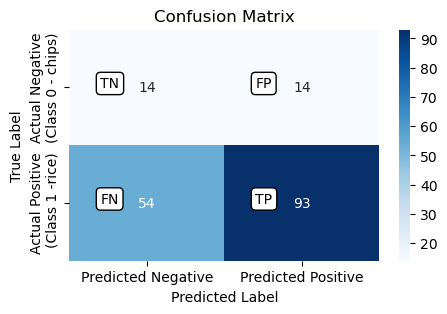

In [251]:
plot_confusion_matrix(svc_y_test, svc_y_pred_test)

True Negatives (TN): 14
instances that are actually in the chips class, and the model correctly predicted them as chips.

False Positives (FP): 14
instances that are actually in the chips class, but the model incorrectly predicted them as rice.

False Negatives (FN): 54
instances that are actually in the rice class, but the model incorrectly predicted them as chips.

True Positives (TP): 93
instances that are actually in the rice class, and the model correctly predicted them as rice.

In [302]:
# results on test subset with default svc model
result = evaluate_SVC_performance(svc, 'Default SVC', svc_X_test_scaled, 'Test Subset', svc_y_test)
svc_results_df = pd.concat([svc_results_df, result], ignore_index=True)
svc_results_df

,Model,Feature_Matrix,C,Gamma,Class_Weight,Accuracy,Precision,Recall,Specificity,F1-score
0,Default SVC,Train Resampled Subset,1.0,scale,None,0.808126,0.907463,0.686230,0.930023,0.781491
1,Default SVC,Validation Subset,1.0,scale,None,0.588571,0.858491,0.614865,0.444444,0.716535
2,Tuned SVC,Train Resampled Subset,0.1,auto,"{0: 1.5, 1: 1}",0.668172,0.874372,0.392777,0.943567,0.542056
3,Tuned SVC,Validation Subset,0.1,auto,"{0: 1.5, 1: 1}",0.428571,0.852941,0.391892,0.629630,0.537037
4,Default SVC,Test Subset,1.0,scale,None,0.611429,0.869159,0.632653,0.500000,0.732283


Accuracy measured as (TP + TN) / Total Count, is 61.14%, reasonably high accuracy. The model correctly labels 61.14% of the dishes suggesting overall reasonable performance in correctly classifying instances.

Precision measured as TP / (TP + FP), is 86.92%, reasonably high precision. From all the predicted dishes as rice, 86.92% are actually rice. The precision is higher due to relatively low FP (14).

Recall measured as TP / (TP + FN), is 63.27%, reasonably high recall. From all the actual rice dishes, the model correctly identified 63.27% suggesting that the model effectively captures a substantial proportion  of positive instances.

Specificity measured as TN / (TN + FP), is 50%, no better than ramdom chance. The model missed the chips dishes half of the time.

The F1 Score measured as (2 x Precision x Recall) / (Precision + Recall), is 73.23%.  It provides a balanced measure of the model's ability to make accurate positive predictions while avoiding false positives and false negatives. The high F1 Score suggests a good balance between precision and recall.

Thus, the Default SVC Model (C=1.0, class_weight=None, gamma='scale'), as configured and trained, predicts the two classes chips and rice accuretely with 61.14%, but there is possibility for improvement.

## 8.3 Random Forest

### 8.3.1 Step 1: Data Splitting

In [220]:
rf_X_train, rf_X_val, rf_X_test, rf_y_train, rf_y_val, rf_y_test = data_splitting(X, y_encoded, test_size=0.4, random_state=42)

Shapes:
Training subset shape: (525, 17)
Validation subset shape: (175, 17)
Test subset shape: (175, 17)


### 8.3.2 Step 2: Model Training

In [221]:
# Train the RFC model with default parameters; random state = 42 to ensure reproducibility
rf = RandomForestClassifier(random_state=42)
rf.fit(rf_X_train, rf_y_train)

RandomForestClassifier(random_state=42)

In [290]:
# results on train subset with default rfc model
rf_results_df = pd.DataFrame()
result = evaluate_RF_performance(rf, 'Default Random Forest Classifier', rf_X_train, 'Train Subset', rf_y_train)
rf_results_df = pd.concat([rf_results_df, result], ignore_index=True)
rf_results_df 

,Model,Feature_Matrix,N estimators,Max Depth,Min Samples Split,Min Samples Leaf,Class Weight,Accuracy,Precision,Recall,Specificity,F1-score
0,Default Random Forest Classifier,Train Subset,100,None,2,1,None,1.0,1.0,1.0,1.0,1.0


The evaluation metrics indicate that the random forest model has achieved perfect performance on the training subset, but there is possibility for overfitting.

The feature importances for the random forest model with default hyperparameters are displayed below.

In [224]:
# feature importances
feature_importances = rf.feature_importances_
rf_feature_names = feature_df.columns  # get column names from feature df

f_importance_df = pd.DataFrame({'Feature': rf_feature_names, 'Importance': feature_importances})
f_importance_df = f_importance_df.sort_values(by='Importance', ascending=False)

print('Feature Importances for the random forest model with default hyperparameters in descending order: of importance')
f_importance_df

Feature Importances for the random forest model with default hyperparameters in descending order: of importance


,Feature,Importance
4,GLCM dissimilarity,0.103562
3,Yellow pixels,0.097510
1,Varience for yellow regions,0.092960
10,HU1 - Translation Invariance,0.092096
2,Skewness for yellow regions,0.090078
0,Mean for yellow regions,0.089766
5,GLCM correlation,0.089561
6,GLCM homogeneity,0.086464
8,STD pixel intensities,0.085406
7,GLCM energy,0.083651


The table shows the feature importances for each feature, as calculated by the Random Forest classifier with default parameters. The importance column represents the contribution of each feature to the model's decision-making process.

The majority of the features have importance above 10%, with the GLCM Dissimilarity having the highest importance with a value 10.36%.

Interestingly, Hu moments for rotation and reflection invarience do not contribute to the model's descion-making process.
From Hu moments features, HU1 moment, which is an invarience to changes in translation, contibutes the most from the Hu moments with a value of 9.21%. HU2 moment, which is invariant to changes in scale, has a smaller importance value of around 1.06% in comparrison to the majority of the features.

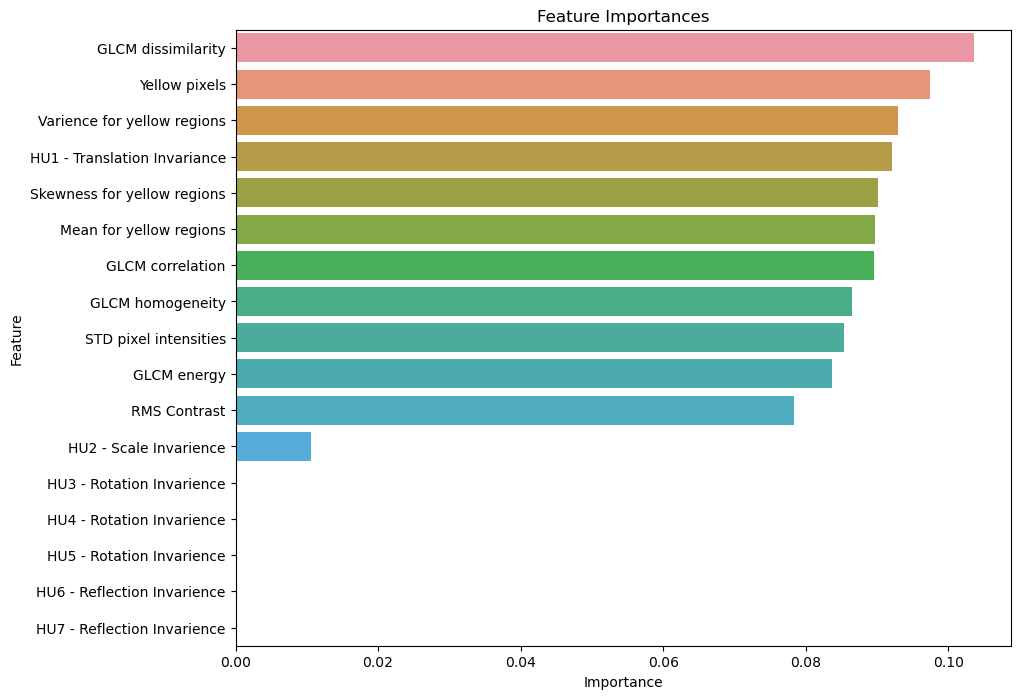

In [225]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=f_importance_df)
plt.title('Feature Importances')
plt.show()

Below the first tree in the forest is visualised.

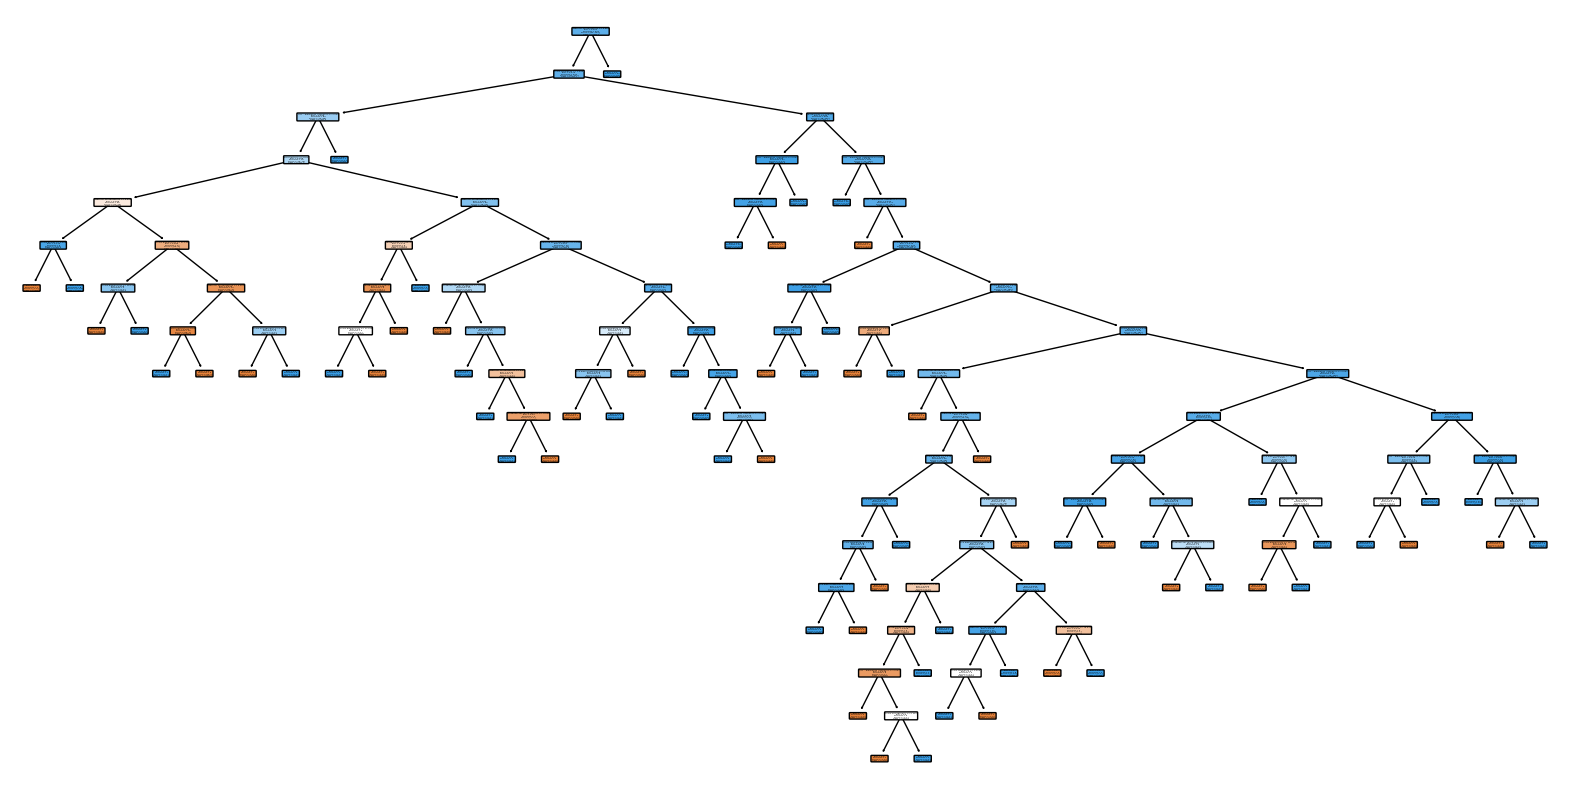

In [226]:
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=rf_feature_names, filled=True, rounded=True, class_names=['Class 0', 'Class 1'])
plt.show()

### 8.3.3 Step 3: Validation and Hyperparameter Tuning

The parameters that are tuned are:

- n_estimators - the number of trees in the forest. Increasing the number of trees usually improves the model's performance.

- max_depth - the maximum depth of the trees and helps prevent overfitting. Higher values for depth tend to model the training data more precisely but might not generalise well to unseen data.

- min_samples_split - the minimum number of samples required to split an internal node. Higher values tend to reduce overfitting.

- min_samples_leaf - the minimum number of samples required to be at a leaf node. Higher values tend to prevent overfitting.

- class_weight - a hyperparameter that assigns different weights to different classes to handle imbalanced data and it could prevent the model from being biased toward the majority of the class.

In [291]:
# results on validation subset with default rfc model
result = evaluate_RF_performance(rf, 'Default Random Forest Classifier', rf_X_val, 'Validation Subset', rf_y_val)
rf_results_df = pd.concat([rf_results_df, result], ignore_index=True)

In [228]:
# randomised search
rf_param_dist = {'n_estimators': [10, 20, 50, 100, 200],
                 'max_depth': randint(2, 20),
                 'min_samples_split': randint(2, 20),
                 'min_samples_leaf': randint(1, 20),
                 'class_weight': ['balanced', 'balanced_subsample', {0: 100, 1: 1}, {0: 10, 1: 1}],
                 'random_state': [42]}

rf_random_search = RandomizedSearchCV(rf, rf_param_dist, n_iter=500, cv=5, scoring='accuracy', random_state=42, verbose=1)
rf_random_search.fit(rf_X_val, rf_y_val)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=500,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         {0: 100, 1: 1},
                                                         {0: 10, 1: 1}],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002CF81916AD0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002CF818CD350>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002CF81290B90>,
                                        'n_estimators': [10, 20, 50, 100, 200],
                                        'random_state': [42]},
                   random_state=42, scoring='accuracy', verbose=1)

In [259]:
# get the tuned rfc model
tuned_rf = rf_random_search.best_estimator_
print('The result for Best RFC Model with 5-fold cross-validation with accuracy as evaluation metric is:')
print(tuned_rf)

The result for Best RFC Model with 5-fold cross-validation with accuracy as evaluation metric is:
RandomForestClassifier(class_weight={0: 10, 1: 1}, max_depth=19,
                       min_samples_split=3, n_estimators=10, random_state=42)


In [230]:
# Retrain the tuned rfc model with the best hyperparameters on the Train Subset
tuned_rf.fit(rf_X_train, rf_y_train)

RandomForestClassifier(class_weight={0: 10, 1: 1}, max_depth=19,
                       min_samples_split=3, n_estimators=10, random_state=42)

In [292]:
# results on train subset with tuned rfc model
result = evaluate_RF_performance(tuned_rf, 'Tuned Random Forest Classifier', rf_X_train, 'Train Subset', rf_y_train)
rf_results_df = pd.concat([rf_results_df, result], ignore_index=True)

In [293]:
# results on validation subset with tuned rfc model
result = evaluate_RF_performance(tuned_rf, 'Tuned Random Forest Classifier', rf_X_val, 'Validation Subset', rf_y_val)
rf_results_df = pd.concat([rf_results_df, result], ignore_index=True)

In [294]:
rf_results_df

,Model,Feature_Matrix,N estimators,Max Depth,Min Samples Split,Min Samples Leaf,Class Weight,Accuracy,Precision,Recall,Specificity,F1-score
0,Default Random Forest Classifier,Train Subset,100,None,2,1,None,1.000000,1.000000,1.000000,1.000000,1.000000
1,Default Random Forest Classifier,Validation Subset,100,None,2,1,None,0.845714,0.845714,1.000000,0.000000,0.916409
2,Tuned Random Forest Classifier,Train Subset,10,19,3,1,"{0: 10, 1: 1}",0.973333,0.971429,0.997743,0.841463,0.984410
3,Tuned Random Forest Classifier,Validation Subset,10,19,3,1,"{0: 10, 1: 1}",0.834286,0.856287,0.966216,0.111111,0.907937


Default RandomForestClassifier (class_weight=none, max_depth=none,
                       min_samples_split=2, n_estimators=100, random_state=42)

Tuned RandomForestClassifier (class_weight={0: 10, 1: 1}, max_depth=19,
                       min_samples_split=3, n_estimators=10, random_state=42)
                       
The default RFC presents exceptional performance on the  train subset, achieving 100% in all metrics. As the train subset has 612 instances, relatively small, this indicates overfitting. The default RFC shows a specificity of 0% on the validation subset, suggesting that there are issues in correctly identifying the minority class: chips.

The tuned RFC displays lower evaluation metrics than the default RFC, apart from specificity on the validation subset. The specificity, essential for correctly identfying the class chips, and suggests that the tuned RFC generalises better on the unseen data than the default RFC model. The rest of the evaluation metrics of the tuned RFC are reasonably high, suggesting overall good performance.

As overfitting is a reasonable concern, the model that would be tested is Tuned RandomForestClassifier with hyperparameters (class_weight={0: 10, 1: 1}, max_depth=19, min_samples_split=3, n_estimators=10, random_state=42)

### 8.3.4 Step 4: Model Evaluation

In [234]:
rf_y_pred_test = tuned_rf.predict(rf_X_test)

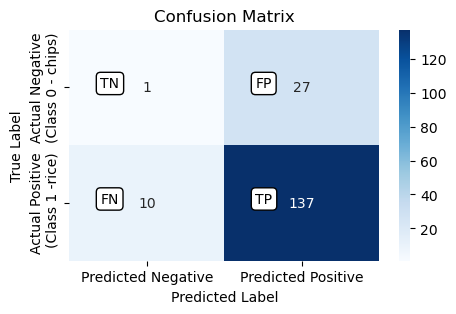

In [235]:
plot_confusion_matrix(rf_y_test, rf_y_pred_test)

True Negatives (TN): 1 instances that are actually in the chips class, and the model correctly predicted them as chips.

False Positives (FP): 27 instances that are actually in the chips class, but the model incorrectly predicted them as rice.

False Negatives (FN): 10 instances that are actually in the rice class, but the model incorrectly predicted them as chips.

True Positives (TP): 137 instances that are actually in the rice class, and the model correctly predicted them as rice.

In [295]:
# results on test subset with tuned rfc model
result = evaluate_RF_performance(tuned_rf, 'Tuned Random Forest Classifier', rf_X_test, 'Test Subset', rf_y_test)
rf_results_df = pd.concat([rf_results_df, result], ignore_index=True)
rf_results_df

,Model,Feature_Matrix,N estimators,Max Depth,Min Samples Split,Min Samples Leaf,Class Weight,Accuracy,Precision,Recall,Specificity,F1-score
0,Default Random Forest Classifier,Train Subset,100,None,2,1,None,1.000000,1.000000,1.000000,1.000000,1.000000
1,Default Random Forest Classifier,Validation Subset,100,None,2,1,None,0.845714,0.845714,1.000000,0.000000,0.916409
2,Tuned Random Forest Classifier,Train Subset,10,19,3,1,"{0: 10, 1: 1}",0.973333,0.971429,0.997743,0.841463,0.984410
3,Tuned Random Forest Classifier,Validation Subset,10,19,3,1,"{0: 10, 1: 1}",0.834286,0.856287,0.966216,0.111111,0.907937
4,Tuned Random Forest Classifier,Test Subset,10,19,3,1,"{0: 10, 1: 1}",0.788571,0.835366,0.931973,0.035714,0.881029


Accuracy measured as (TP + TN) / Total Count, is 78.86%, reasonably high accuracy. The model correctly labels 78.86% of the dishes suggesting overall reasonable performance in correctly classifying instances.

Precision measured as TP / (TP + FP), is 83.54%, reasonably high precision. From all the predicted dishes as rice, 83.54% are actually rice.

Recall measured as TP / (TP + FN), is 93.20%, reasonably high recall. From all the actual rice dishes, the model correctly identified 93.20%, suggesting that the model is effective in identifying the positive instances. The precision is higher due to relatively low FP (10).

Specificity measured as TN / (TN + FP), is 3.57%, significantly low specificity. From all the actual chips dishes, the model identified only 3.57% suggesting that the model missed the chips dishes more than 90% of the time.

The F1 Score measured as (2 x Precision x Recall) / (Precision + Recall), is 88.10%.  It provides a balanced measure of the model's ability to make accurate positive predictions while avoiding false positives and false negatives. The high F1 Score suggests a good balance between precision and recall.

Thus, the Tuned RandomForestClassifier with hyperparameters (class_weight={0: 10, 1: 1}, max_depth=19, min_samples_split=3, n_estimators=10, random_state=42), as configered and trained, is reasonably effective in predicting the rice class, but there is room for improvement as the model experiences challenges in correctly identifying the chips class.

# 9 Conclusions

Results for trained models on test subset (unseen data):

1. **Tuned Logistic Regression:**
   - Accuracy: 0.594286
   - Precision: 0.865385
   - Recall: 0.612245
   - Specificity: 0.5
   - F1-score: 0.717131

2. **Default SVC:**
   - Accuracy: 0.611429
   - Precision: 0.869159
   - Recall: 0.632653
   - Specificity: 0.5
   - F1-score: 0.732283

3. **Tuned Random Forest Classifier:**
   - Accuracy: 0.788571
   - Precision: 0.835366
   - Recall: 0.931973
   - Specificity: 0.035714
   - F1-score: 0.881029

The **Tuned Random Forest Classifier** seems to perform the best among the models, having a higher accuracy and well-balanced precision and recall.

**Further considerations for improvement involve:**
- the use of different resampling techniques that can help better address imbalance classes;
- conducting a more extensive hyperparameter search;
- evaluating the grid search on different scoring metrics like f1-score or area under the curve (AUC-ROC);
- exploring additional features or transforming addtional ones to better capture underlying patterns in the data;
- use of feature selecting techniques to identify the most informative features and discard the irrelevant ones;
- for Linear Regression: using different solvers
- for SVC: experimenting with other kernels like linear, polynomial, or sigmoid to reveal different decision boundaries;
- for RFC: imporve specificity to correctly label chips
- using a robust cross-validation strategy
- use of interpretable models or methods to provide insights into feature importance.
- explore other classification algorithms.